In [1]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from typing import Callable, Optional
from probe_model import DRCProbe
from create_probe_dataset import ProbingDataset
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch.nn.functional as F
import pandas as pd
import numpy as np
from celluloid import Camera
from thinker.actor_net import DRCNet
import os
import random

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-02 19:45:01,494	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



In [2]:
val_data = torch.load("./data/val_data_full.pt")

In [8]:
episode_entry = val_data[:29]

In [14]:
len(episode_entry[:])

29

In [35]:
for trans_idx, trans in enumerate(episode_entry):
    board_locs = torch.zeros((8,8), dtype=int)
    for loc_idx in range(64):
        for future_trans in episode_entry[trans_idx+1:]:
            if loc_idx in future_trans["tracked_box_loc_change_after_action_1"]:
                board_locs[loc_idx%8, (loc_idx-loc_idx%8)//8] = 1
            elif loc_idx in future_trans["tracked_box_loc_change_after_action_2"]:
                board_locs[loc_idx%8, (loc_idx-loc_idx%8)//8] = 2
            elif loc_idx in future_trans["tracked_box_loc_change_after_action_3"]:
                board_locs[loc_idx%8, (loc_idx-loc_idx%8)//8] = 3
            elif loc_idx in future_trans["tracked_box_loc_change_after_action_4"]:
                board_locs[loc_idx%8, (loc_idx-loc_idx%8)//8] = 4
    trans["tracked_box_next_push_onto_after"] = board_locs

In [36]:
episode_entry[-9]["tracked_box_next_push_onto_after"],  episode_entry[-9]["board_state"][-1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 3, 0, 0, 0],
         [0, 0, 0, 0, 3, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8))

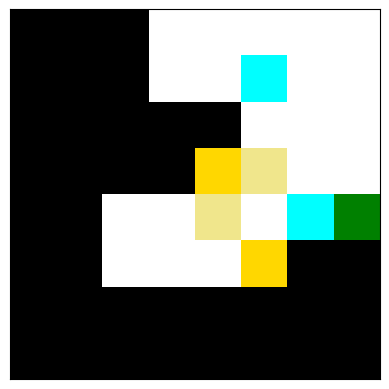

In [29]:
viz.plot_mini_sokoban(episode_entry[-9]["board_state"])

In [13]:
episode_entry[0]["tracked_box_loc_change_action_1"] = tuple()
episode_entry[0]["tracked_box_loc_change_action_2"] = tuple()
episode_entry[0]["tracked_box_loc_change_action_3"] = tuple()
episode_entry[0]["tracked_box_loc_change_action_4"] = tuple()
for trans_idx, trans in enumerate(episode_entry[1:]):
    trans["tracked_box_loc_change_action_1"] = tuple()
    trans["tracked_box_loc_change_action_2"] = tuple()
    trans["tracked_box_loc_change_action_3"] = tuple()
    trans["tracked_box_loc_change_action_4"] = tuple()
    if trans["tracked_box_loc"] != episode_entry[trans_idx]["tracked_box_loc"]:
        for i in range(4):
            if trans["tracked_box_loc"][i] != episode_entry[trans_idx]["tracked_box_loc"][i]:
                trans[f"tracked_box_loc_change_action_{episode_entry[trans_idx]['action']}"] = trans["tracked_box_loc"][i]

In [18]:
for trans in episode_entry:
    print(trans["tracked_box_loc"], trans["action"], trans["tracked_box_loc_change_after_action_1"], trans["tracked_box_loc_change_after_action_2"], trans["tracked_box_loc_change_after_action_3"], trans["tracked_box_loc_change_after_action_4"])

(13, 14, 22, 38) 3 () () () ()
(13, 14, 22, 38) 3 () () () ()
(13, 14, 22, 38) 2 () () () ()
(21, 14, 22, 38) 2 () (21,) () ()
(29, 14, 22, 38) 2 () (29,) () ()
(37, 14, 22, 38) 2 () (37,) () ()
(45, 14, 22, 38) 1 () (45,) () ()
(45, 14, 22, 38) 4 () () () ()
(45, 14, 22, 38) 4 () () () ()
(45, 14, 22, 38) 1 () () () ()
(45, 14, 22, 38) 1 () () () ()
(45, 14, 22, 38) 3 () () () ()
(45, 13, 22, 38) 2 () () (13,) ()
(45, 13, 30, 38) 4 () (30,) () ()
(45, 13, 30, 38) 2 () () () ()
(45, 13, 30, 38) 3 () () () ()
(45, 13, 29, 38) 3 () () (29,) ()
(45, 13, 28, 38) 4 () () (28,) ()
(45, 13, 28, 38) 4 () () () ()
(45, 13, 28, 38) 2 () () () ()
(45, 13, 28, 38) 3 () () () ()
(45, 13, 28, 37) 3 () () (37,) ()
(45, 13, 28, 36) 4 () () (36,) ()
(45, 13, 28, 36) 1 () () () ()
(45, 13, 28, 36) 1 () () () ()
(45, 13, 28, 36) 1 () () () ()
(45, 13, 28, 36) 1 () () () ()
(45, 13, 28, 36) 3 () () () ()
(45, 13, 28, 36) 2 () () () ()


In [69]:
# track number of turns since each tracked box last moved
tracked_box_locs = episode_entry[0]["tracked_box_loc"]
episode_entry[0]["tracked_box_loc_since_last_moved"] = (42, 42, 42, 42)
old_last_moved = episode_entry[0]["tracked_box_loc_since_last_moved"]
for trans_idx, trans in enumerate(episode_entry):
    current_box_locs = trans["tracked_box_loc"]
    trans["tracked_box_loc_since_last_moved"] = tuple([old_last_moved[i]+1 if current_box_locs[i]==tracked_box_locs[i] else 0 for i in range(4)])
    old_last_moved = trans["tracked_box_loc_since_last_moved"]
    if current_box_locs != tracked_box_locs:
        tracked_box_locs = current_box_locs

In [70]:
# track square from which agent next pushes box with >1 step gap between pushing it
for trans_idx, trans in enumerate(episode_entry):
    if trans_idx == len(episode_entry)-1:
        if len(episode_entry) > 110: # 
          trans["start_move_box"] = 0 # kind of a weird one: if level is unsolved, then *empirically* agent paces and never seems to move another box
        elif sum([1 if trans["tracked_box_loc_since_last_moved"][i] != 0 else 0 for i in range(4)]) != 0:
            trans["start_move_box"] = 1
        else:
            trans["start_move_box"] = 0
    elif sum([1 if (episode_entry[trans_idx+1]["tracked_box_loc_since_last_moved"][i] == 0 and trans["tracked_box_loc_since_last_moved"][i] != 0) else 0 for i in range(4)]) != 0:
        trans["start_move_box"] = 1
    else:
        trans["start_move_box"] = 0
for trans_idx, trans in enumerate(episode_entry):
    i = 0
    while True:
        if episode_entry[trans_idx+i]["start_move_box"] == 1:
            trans["next_start_move_box_loc"] = episode_entry[trans_idx+i]["agent_loc"]
            break
        elif trans_idx+i == len(episode_entry)-1:
            trans["next_start_move_box_loc"] = -1 # if agent doesn't move a box for the rest of the episode, no feature
            break
        else:
            i += 1

In [73]:
for trans_idx, trans in enumerate(episode_entry):
    if trans_idx == len(episode_entry)-1:
        trans["end_box_move"] = 0 # if episode terminates without solving, agent paces and will not be pushing box on final step; if next turn is termination, agent cannot push and then take a break
    elif sum([1 if (trans["tracked_box_loc_since_last_moved"][i] == 0 and episode_entry[trans_idx+1]["tracked_box_loc_since_last_moved"][i] != 0) else 0 for i in range(4)]) != 0:
        trans["end_box_move"] = 1
    else:
        trans["end_box_move"] = 0
for trans_idx, trans in enumerate(episode_entry):
    i = 1
    while True:
        if trans_idx+i >= len(episode_entry):
            if len(episode_entry) > 110:
                trans["next_end_move_box_loc"] = -1 # if episode isn't solved, assume final step is not pushing a box for future movement (makes sense)
            else:
                trans["next_end_move_box_loc"] = trans["justtar_loc"][0] # if final step in solved level, will just be pushing box onto target
            break
        elif episode_entry[trans_idx+i]["end_box_move"] == 1:
            print(trans_idx)
            print("current", trans["tracked_box_loc"])
            print("future", episode_entry[trans_idx+i]["tracked_box_loc"])
            trans["next_end_move_box_loc"] = [episode_entry[trans_idx+i]["tracked_box_loc"][j] for j in range(len(trans["tracked_box_loc"])) if trans["tracked_box_loc"][j]!=episode_entry[trans_idx+i]["tracked_box_loc"][j]][0]
            break
        else:
            i += 1

0
current (13, 14, 22, 38)
future (45, 14, 22, 38)
1
current (13, 14, 22, 38)
future (45, 14, 22, 38)
2
current (13, 14, 22, 38)
future (45, 14, 22, 38)
3
current (21, 14, 22, 38)
future (45, 14, 22, 38)
4
current (29, 14, 22, 38)
future (45, 14, 22, 38)
5
current (37, 14, 22, 38)
future (45, 14, 22, 38)
6
current (45, 14, 22, 38)
future (45, 13, 22, 38)
7
current (45, 14, 22, 38)
future (45, 13, 22, 38)
8
current (45, 14, 22, 38)
future (45, 13, 22, 38)
9
current (45, 14, 22, 38)
future (45, 13, 22, 38)
10
current (45, 14, 22, 38)
future (45, 13, 22, 38)
11
current (45, 14, 22, 38)
future (45, 13, 22, 38)
12
current (45, 13, 22, 38)
future (45, 13, 30, 38)
13
current (45, 13, 30, 38)
future (45, 13, 28, 38)
14
current (45, 13, 30, 38)
future (45, 13, 28, 38)
15
current (45, 13, 30, 38)
future (45, 13, 28, 38)
16
current (45, 13, 29, 38)
future (45, 13, 28, 38)
17
current (45, 13, 28, 38)
future (45, 13, 28, 36)
18
current (45, 13, 28, 38)
future (45, 13, 28, 36)
19
current (45, 13, 28

In [30]:
# track box_locs
tracked_box_locs = [episode_entry[0]["box_loc"][i] for i in range(4)]
episode_entry[0]["tracked_box_loc"] = tuple([tracked_box_locs[i] for i in range(4)])
for trans in episode_entry[1:]:
    trans_box_locs = trans["box_loc"]
    for i in range(4):
        if tracked_box_locs[i] not in trans_box_locs:
            for j in range(4):
                if trans_box_locs[j] not in tracked_box_locs:
                    tracked_box_locs[i] = trans_box_locs[j]
    trans["tracked_box_loc"] = tuple([tracked_box_locs[i] for i in range(4)])

# get final position of boxes
tracked_box_locs_final = [box_loc for box_loc in episode_entry[-1]["tracked_box_loc"]]
for k in range(4):
    if tracked_box_locs_final[k] not in episode_entry[-1]["tar_loc"]:
        for s in range(4):
            if episode_entry[-1]["tar_loc"][s] not in tracked_box_locs_final:
                tracked_box_locs_final[k] = episode_entry[-1]["tar_loc"][s]

# track next box to move
for trans_idx, trans in enumerate(episode_entry):
    current_box_locs = trans["tracked_box_loc"]
    i = 0
    while True:
        if current_box_locs != episode_entry[trans_idx+i]["tracked_box_loc"]:
            changed_box_locs = episode_entry[trans_idx+i]["tracked_box_loc"]
            break
        elif trans_idx+i==len(episode_entry)-1:
            changed_box_locs = tracked_box_locs_final
            break
        else:
            i += 1
    for j in range(4):
        if current_box_locs[j] != changed_box_locs[j]:
            trans["tracked_box_loc_next_idx"] = j
    trans["tracked_box_loc_next"] = trans["tracked_box_loc"][trans["tracked_box_loc_next_idx"]]

# track if box moves for rest of episode, and track active boxes:
episode_entry[-1]["box_loc_final"] = tuple([1 if episode_entry[-1]["tracked_box_loc"][i] in tracked_box_locs_final else 0 for i in range(4)])
for i in range(len(episode_entry)-1):
    current_box_locs = episode_entry[-(i+2)]["tracked_box_loc"]
    future_box_locs = episode_entry[-(i+1)]["tracked_box_loc"]
    future_box_locs_final = episode_entry[-(i+1)]["box_loc_final"]
    current_box_locs_final = tuple([1 if (current_box_locs[j]==future_box_locs[j] and future_box_locs_final[j]==1) else 0 for j in range(4)])
    episode_entry[-(i+2)]["box_loc_final"] = current_box_locs_final
for trans in episode_entry:
    trans["tracked_box_loc_active"] = tuple([trans["tracked_box_loc"][i] for i in range(4) if trans["box_loc_final"][i]==0])

In [39]:
episode_entry = val_data[:25]

In [32]:
# track state of each target
for trans in episode_entry:
    tar_states = [0, 0, 0, 0]
    for i in range(4):
        if trans["tar_loc"][i] in trans["boxontar_loc"]:
            tar_states[i] = 1
    trans["tar_state"] = tuple(tar_states)
# track if each target in its final state
episode_entry[-1]["tar_state_final"] = tuple([1 if episode_entry[-1]["tar_state"][i]==1 else 0 for i in range(4)])
for i in range(len(episode_entry)-1):
    current_tar_locs = episode_entry[-(i+2)]["tar_state"]
    future_tar_locs = episode_entry[-(i+1)]["tar_state"]
    future_tar_locs_final = episode_entry[-(i+1)]["tar_state_final"]
    current_tar_locs_final = tuple([1 if (current_tar_locs[j]==future_tar_locs[j] and future_tar_locs_final[j]==1) else 0 for j in range(4)])
    episode_entry[-(i+2)]["tar_state_final"] = current_tar_locs_final
    if sum(current_tar_locs_final) == 0:
        break
# track next box to move
for trans_idx, trans in enumerate(episode_entry):
    current_tar_locs = trans["tar_state"]
    i = 0
    while current_tar_locs == episode_entry[trans_idx+i]["tar_state"] and trans_idx+i<len(episode_entry)-1:
        i += 1
        if current_tar_locs != episode_entry[trans_idx+i]["tar_state"]:
            changed_tar_locs = episode_entry[trans_idx+i]["tar_state"]
            changed_tar_idx = [i for i in range(4) if changed_tar_locs[i]!=current_tar_locs[i]][0]
            if sum([1 for future_trans in episode_entry[trans_idx+i+1:] if future_trans["tar_state"][changed_tar_idx]!=changed_tar_locs[changed_tar_idx]]) == 0:
                break
        elif trans_idx+i<len(episode_entry)-1:
            changed_tar_locs = tuple([1, 1, 1, 1])
    for j in range(4):
        if current_tar_locs[j] != changed_tar_locs[j]:
            trans["tar_next_idx"] = j
    trans["tar_next"] = trans["tar_loc"][trans["tar_next_idx"]]

In [89]:
# track next box to move
for trans_idx, trans in enumerate(episode_entry):
    current_box_locs = trans["tar_state"]
    i = 0
    while current_box_locs == episode_entry[trans_idx+i]["tar_state"] and trans_idx+i<len(episode_entry)-1:
        i += 1
        if current_box_locs != episode_entry[trans_idx+i]["tar_state"]:
            changed_box_locs = episode_entry[trans_idx+i]["tar_state"]
            break
        elif trans_idx+i<len(episode_entry)-1:
            changed_box_locs = tuple([1, 1, 1, 1])
    for j in range(4):
        if current_box_locs[j] != changed_box_locs[j]:
            trans["tar_next_idx"] = j
    trans["tar_next"] = trans["tar_loc"][trans["tar_next_idx"]]

In [37]:
for trans in episode_entry:
    print(trans["tar_loc"], trans["tracked_box_loc"], trans["tar_state_final"], trans["tar_next"])

(9, 18, 35, 42) (25, 41, 49, 50) (0, 0, 0, 0) (18,)
(9, 18, 35, 42) (25, 41, 49, 50) (0, 0, 0, 0) (18,)
(9, 18, 35, 42) (25, 41, 49, 50) (0, 0, 0, 0) (18,)
(9, 18, 35, 42) (25, 41, 49, 42) (0, 0, 0, 0) (42,)
(9, 18, 35, 42) (25, 41, 49, 34) (0, 0, 0, 0) (18,)
(9, 18, 35, 42) (25, 41, 49, 26) (0, 0, 0, 0) (18,)
(9, 18, 35, 42) (25, 41, 49, 18) (0, 1, 0, 0) (9,)
(9, 18, 35, 42) (25, 41, 49, 18) (0, 1, 0, 0) (9,)
(9, 18, 35, 42) (25, 41, 49, 18) (0, 1, 0, 0) (9,)
(9, 18, 35, 42) (17, 41, 49, 18) (0, 1, 0, 0) (9,)
(9, 18, 35, 42) (9, 41, 49, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 49, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 49, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 49, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 49, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 49, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 50, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 50, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 50, 18) (1, 1, 0, 0) (42,)
(9, 18, 35, 42) (9, 41, 4

In [168]:
weight = torch.tensor([[ 0.0931,  0.7003,  2.3075, -1.6211, -1.3087, -1.2094, -0.3529,  2.4272],
        [-0.0997, -0.7995, -2.4832,  1.6891,  1.0692,  1.1532,  0.1971, -2.4617]])

In [3]:
def make_plan_gif_across_layers(episode_entry, gif_file=".", gif_name="test"):

    weight0 = torch.tensor([[-0.6837276816368103, 0.08642134815454483, 2.5258469581604004, -0.4921751320362091, 1.2463593482971191, -0.9867230653762817, 0.04729536920785904, 0.28849849104881287, -0.36138322949409485,
  -0.07113686203956604, 0.845041811466217, 0.5488023161888123, -0.7671644687652588, -0.9444531798362732, 0.32021957635879517, -0.4225016236305237, -0.5519166588783264, -0.18044862151145935,
  -0.07549270242452621, -0.24302361905574799, 1.2557265758514404, -0.30061808228492737, -2.907780885696411, 0.8218410611152649, 0.4042874872684479, 1.6314572095870972, 0.01599644124507904,
  -0.5025864243507385, -0.13576439023017883, 0.030720066279172897, 0.9375211000442505, -0.764415442943573], 
  [0.6836835145950317, 0.10610787570476532, -2.771732807159424, 0.5924633741378784, -1.0194385051727295, 1.1957374811172485, -0.3550739586353302, -0.49757081270217896, 0.2513337731361389, 0.18318021297454834,
    -0.7606615424156189, -0.6022713780403137, 0.5610904693603516, 1.1221269369125366, -0.5702047944068909, 0.3721276819705963, 0.3870593309402466, 0.1603395789861679, 0.32394319772720337, 
    0.08686233311891556, -1.2280259132385254, 0.018737254664301872, 3.1480674743652344, -0.7804999351501465, -0.47075358033180237, -1.657581090927124, -0.2025476098060608, 0.7297380566596985,
      0.02321203611791134, -0.038493599742650986, -0.8022414445877075, 0.9820601940155029]])

    weight1 = torch.tensor([[-0.3309761583805084, 1.531782627105713, 1.3465176820755005, -0.19540958106517792, 1.6348158121109009, 0.11338530480861664, 0.8540199398994446, -0.6451936364173889, 0.7114246487617493,
   0.18536025285720825, -1.0371973514556885, -0.9517309665679932, 0.4352772831916809, -0.14601603150367737, -0.39273589849472046, -0.19588740170001984, -0.35819610953330994, 0.43284204602241516,
     0.19508232176303864, -0.42335090041160583, -1.8579126596450806, -0.24377398192882538, 0.534830629825592, 0.5655252933502197, 0.34142738580703735, -0.32439976930618286, -0.22047798335552216,
       2.4178175926208496, 0.7043865323066711, -0.11321786046028137, 0.32928624749183655, 0.3327062129974365], 
       [0.511059582233429, -1.6108510494232178, -1.2262520790100098, 0.012695379555225372, -1.6715184450149536, -0.06787911802530289, -0.6515945792198181, 0.6064745187759399, -0.5865893363952637, 
        -0.049905773252248764, 0.9452276229858398, 1.043906569480896, -0.21981965005397797, -0.013025883585214615, 0.5620828866958618, 0.18030057847499847, 0.2156665027141571, -0.15766671299934387, 
        -0.09356295317411423, 0.23489437997341156, 2.0007996559143066, 0.20852892100811005, -0.46883001923561096, -0.7459681034088135, -0.25280988216400146, 0.4206063449382782, 0.3014945685863495, 
        -2.437561273574829, -0.594936728477478, 0.24333608150482178, -0.3691480755805969, -0.30693021416664124]])

    weight2 = torch.tensor([[-0.48737913370132446, 2.0204238891601562, -0.20710276067256927, -0.1559930294752121, -1.4778072834014893, 1.0226231813430786, -0.011008787900209427, 0.26454436779022217,
                             0.5662028789520264, 0.826072633266449, 0.7518832087516785, 0.4854520261287689, -0.545423686504364, -0.1605425626039505, -2.30305552482605, 0.10711660981178284,
                               -0.20925910770893097, -0.4371994435787201, -0.09227673709392548, 0.2594224214553833, 0.09071329236030579, -0.10446739196777344, -0.008032598532736301, -0.6721022725105286, 
                               0.14969028532505035, -0.5917406678199768, 0.7830581068992615, -0.018811164423823357, 0.2390570491552353, 0.2955656945705414, -1.1725964546203613, 0.9227076768875122],
                                 [0.6500030755996704, -1.9482715129852295, 0.21371221542358398, -0.007815630175173283, 1.2696133852005005, -0.7610629200935364, 0.0742838978767395, -0.525004506111145, 
                                  -0.3204478919506073, -0.8447422981262207, -0.5190479755401611, -0.7739930152893066, 0.6830257177352905, 0.15014739334583282, 2.5916659832000732, -0.32344695925712585, 
                                  0.09805583208799362, 0.6653913259506226, 0.010809963569045067, -0.0951007530093193, 0.04532609134912491, -0.021794166415929794, 0.18280953168869019, 0.7764242887496948, 
                                  -0.0533781498670578, 0.40867361426353455, -0.7241909503936768, 0.18064184486865997, -0.30017533898353577, -0.36463192105293274, 1.2368476390838623, -0.9249445199966431]])
    channels = list(range(32))
    fig, axs = plt.subplots(1,4)
    camera = Camera(fig)
    for trans_idx, trans in enumerate(episode_entry):
        for tick_idx in range(1,4):

            map0 = torch.zeros(size=(2,8,8))
            for i in range(len(channels)):
                map0[0] += trans["hidden_states"][tick_idx,32+channels[i],:,:] * weight0[0,i]
                map0[1] += trans["hidden_states"][tick_idx,32+channels[i],:,:] * weight0[1,i]
            map1 = torch.zeros(size=(2,8,8))
            for i in range(len(channels)):
                map1[0] += trans["hidden_states"][tick_idx,96+channels[i],:,:] * weight1[0,i]
                map1[1] += trans["hidden_states"][tick_idx,96+channels[i],:,:] * weight1[1,i]
            map2 = torch.zeros(size=(2,8,8))
            for i in range(len(channels)):
                map2[0] += trans["hidden_states"][tick_idx,160+channels[i],:,:] * weight2[0,i]
                map2[1] += trans["hidden_states"][tick_idx,160+channels[i],:,:] * weight2[1,i]

            state = trans["board_state"]
            if state.shape[0] != state.shape[1]:
                state = state.permute(1,2,0)
            dim_z = 7
            mini_board = np.zeros(state.shape[:-1])
            for i in range(1,1+dim_z):
                mini_board[(state[:,:,i-1] == 1)] = i
            mini_board = np.flip(mini_board, axis=0)
            cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
            bounds= [i+0.5 for i in range(1+dim_z)]
            norm = colors.BoundaryNorm(bounds, cmap.N)
            axs[0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
            axs[0].axes.get_yaxis().set_visible(False)
            axs[0].axes.get_xaxis().set_visible(False)
            axs[0].text(0.3, 1.01, f'transition {trans_idx+1}', transform=axs[0].transAxes)
            axs[1].imshow(map0.argmax(dim=0), vmin=-1,vmax=1)
            axs[1].axes.get_yaxis().set_visible(False)
            axs[1].axes.get_xaxis().set_visible(False)
            axs[1].text(0.4, 1.01, f'layer 0', transform=axs[1].transAxes)
            axs[2].imshow(map1.argmax(dim=0), vmin=-1,vmax=1)
            axs[2].axes.get_yaxis().set_visible(False)
            axs[2].axes.get_xaxis().set_visible(False)
            axs[2].text(0.4, 1.01, f'layer 1', transform=axs[2].transAxes)
            axs[3].imshow(map2.argmax(dim=0), vmin=-1,vmax=1)
            axs[3].axes.get_yaxis().set_visible(False)
            axs[3].axes.get_xaxis().set_visible(False)
            axs[3].text(0.4, 1.01, f'layer 2', transform=axs[3].transAxes)
            plt.pause(0.1)
            camera.snap()
    animation = camera.animate()
    animation.save(f"{gif_file}/{gif_name}.gif", writer='PillowWriter', fps=1)

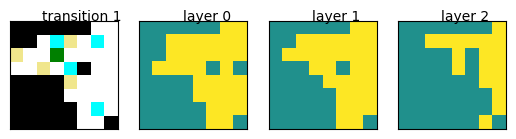

MovieWriter PillowWriter unavailable; using Pillow instead.


In [31]:
make_plan_gif_across_layers(val_data[370:410], gif_file="./plan_viz", gif_name="val_ep4_layers")

In [3]:
weight0 = torch.tensor([[-0.6837276816368103, 0.08642134815454483, 2.5258469581604004, -0.4921751320362091, 1.2463593482971191, -0.9867230653762817, 0.04729536920785904, 0.28849849104881287, -0.36138322949409485,
-0.07113686203956604, 0.845041811466217, 0.5488023161888123, -0.7671644687652588, -0.9444531798362732, 0.32021957635879517, -0.4225016236305237, -0.5519166588783264, -0.18044862151145935,
-0.07549270242452621, -0.24302361905574799, 1.2557265758514404, -0.30061808228492737, -2.907780885696411, 0.8218410611152649, 0.4042874872684479, 1.6314572095870972, 0.01599644124507904,
-0.5025864243507385, -0.13576439023017883, 0.030720066279172897, 0.9375211000442505, -0.764415442943573], 
[0.6836835145950317, 0.10610787570476532, -2.771732807159424, 0.5924633741378784, -1.0194385051727295, 1.1957374811172485, -0.3550739586353302, -0.49757081270217896, 0.2513337731361389, 0.18318021297454834,
-0.7606615424156189, -0.6022713780403137, 0.5610904693603516, 1.1221269369125366, -0.5702047944068909, 0.3721276819705963, 0.3870593309402466, 0.1603395789861679, 0.32394319772720337, 
0.08686233311891556, -1.2280259132385254, 0.018737254664301872, 3.1480674743652344, -0.7804999351501465, -0.47075358033180237, -1.657581090927124, -0.2025476098060608, 0.7297380566596985,
    0.02321203611791134, -0.038493599742650986, -0.8022414445877075, 0.9820601940155029]])

weight1 = torch.tensor([[-0.3309761583805084, 1.531782627105713, 1.3465176820755005, -0.19540958106517792, 1.6348158121109009, 0.11338530480861664, 0.8540199398994446, -0.6451936364173889, 0.7114246487617493,
0.18536025285720825, -1.0371973514556885, -0.9517309665679932, 0.4352772831916809, -0.14601603150367737, -0.39273589849472046, -0.19588740170001984, -0.35819610953330994, 0.43284204602241516,
    0.19508232176303864, -0.42335090041160583, -1.8579126596450806, -0.24377398192882538, 0.534830629825592, 0.5655252933502197, 0.34142738580703735, -0.32439976930618286, -0.22047798335552216,
    2.4178175926208496, 0.7043865323066711, -0.11321786046028137, 0.32928624749183655, 0.3327062129974365], 
    [0.511059582233429, -1.6108510494232178, -1.2262520790100098, 0.012695379555225372, -1.6715184450149536, -0.06787911802530289, -0.6515945792198181, 0.6064745187759399, -0.5865893363952637, 
    -0.049905773252248764, 0.9452276229858398, 1.043906569480896, -0.21981965005397797, -0.013025883585214615, 0.5620828866958618, 0.18030057847499847, 0.2156665027141571, -0.15766671299934387, 
    -0.09356295317411423, 0.23489437997341156, 2.0007996559143066, 0.20852892100811005, -0.46883001923561096, -0.7459681034088135, -0.25280988216400146, 0.4206063449382782, 0.3014945685863495, 
    -2.437561273574829, -0.594936728477478, 0.24333608150482178, -0.3691480755805969, -0.30693021416664124]])

weight2 = torch.tensor([[-0.48737913370132446, 2.0204238891601562, -0.20710276067256927, -0.1559930294752121, -1.4778072834014893, 1.0226231813430786, -0.011008787900209427, 0.26454436779022217,
                            0.5662028789520264, 0.826072633266449, 0.7518832087516785, 0.4854520261287689, -0.545423686504364, -0.1605425626039505, -2.30305552482605, 0.10711660981178284,
                            -0.20925910770893097, -0.4371994435787201, -0.09227673709392548, 0.2594224214553833, 0.09071329236030579, -0.10446739196777344, -0.008032598532736301, -0.6721022725105286, 
                            0.14969028532505035, -0.5917406678199768, 0.7830581068992615, -0.018811164423823357, 0.2390570491552353, 0.2955656945705414, -1.1725964546203613, 0.9227076768875122],
                                [0.6500030755996704, -1.9482715129852295, 0.21371221542358398, -0.007815630175173283, 1.2696133852005005, -0.7610629200935364, 0.0742838978767395, -0.525004506111145, 
                                -0.3204478919506073, -0.8447422981262207, -0.5190479755401611, -0.7739930152893066, 0.6830257177352905, 0.15014739334583282, 2.5916659832000732, -0.32344695925712585, 
                                0.09805583208799362, 0.6653913259506226, 0.010809963569045067, -0.0951007530093193, 0.04532609134912491, -0.021794166415929794, 0.18280953168869019, 0.7764242887496948, 
                                -0.0533781498670578, 0.40867361426353455, -0.7241909503936768, 0.18064184486865997, -0.30017533898353577, -0.36463192105293274, 1.2368476390838623, -0.9249445199966431]])

In [7]:
# box after 1
weight0 = torch.tensor([[0.001336743007414043, 0.2774198055267334, -1.085297703742981, 0.0004181009717285633, 0.4033251702785492, 0.25687751173973083,
             -0.6270604729652405, 0.704028308391571, -0.14271016418933868, -0.22128094732761383, -0.2806873321533203, 0.17426711320877075, 
             -1.143330454826355, -0.3845312297344208, 0.33654388785362244, -0.04059305414557457, -0.25335046648979187, 0.42080360651016235, 
             -0.12418463826179504, -2.199221611022949, 0.12018437683582306, -0.2612112760543823, -0.14805389940738678, 0.11809773743152618, 
             2.788121223449707, -0.12639835476875305, -0.24924400448799133, -0.4128364324569702, 0.16791850328445435, 0.752255916595459, 
             -0.06588687002658844, -0.43176135420799255], 
             [0.03827228397130966, -0.043883685022592545, 0.9231773614883423, 0.18201163411140442, -0.35634759068489075, -0.3868766129016876, 
              0.43600526452064514, -0.7173547148704529, -0.011773288249969482, 0.3211146891117096, 0.23308302462100983, -0.21308687329292297, 
              1.2597782611846924, 0.46995478868484497, -0.44231948256492615, -0.0126330042257905, 0.1988467425107956, -0.6146513223648071, 
              0.1464768648147583, 2.2252025604248047, 0.019447658210992813, 0.33224785327911377, 0.3031160533428192, -0.1136193722486496,
                -2.7669482231140137, -0.13524164259433746, 0.16741524636745453, 0.43720415234565735, -0.014332041144371033, -0.7987852096557617, 
                0.033024173229932785, 0.5685760378837585]])
weight1 = torch.tensor([[-0.3601422905921936, 0.37479957938194275, 0.5382915139198303, -1.915297508239746, -0.5164673924446106, -1.5197384357452393, 
            0.3926107585430145, 0.11871916800737381, 0.4126772880554199, -0.25805896520614624, 0.05387125909328461, -0.6716681718826294,
              0.43278932571411133, 0.09914565831422806, -0.07557046413421631, 0.05131509527564049, 0.043652284890413284, -0.16775821149349213, 
              0.5536526441574097, 0.12110218405723572, 0.9992712736129761, -1.5956670045852661, -0.2866053581237793, 0.5077732801437378, 
              0.7676562666893005, 0.6247000098228455, 0.2254088670015335, 0.5790913105010986, -0.6861674785614014, 0.6776795387268066, 
              0.1731213629245758, 0.3260558843612671], 
              [0.324062317609787, -0.35808223485946655, -0.3436587154865265, 1.948724389076233, 0.6602081656455994, 1.6287975311279297, 
               -0.5841515064239502, -0.0681132823228836, -0.36145728826522827, 0.1061822772026062, -0.11150733381509781, 0.762453556060791,
                 -0.650684654712677, 0.10401228815317154, 0.18642063438892365, -0.18922169506549835, -0.07684294879436493, -0.014898675493896008,
                   -0.5394862294197083, 0.11644598841667175, -0.9484301805496216, 1.4069980382919312, 0.11445640027523041, -0.4663500487804413, 
                   -0.7701870799064636, -0.7420022487640381, -0.11071477085351944, -0.40709638595581055, 0.37044617533683777, -0.653186559677124,
                     -0.0010462749050930142, -0.33778515458106995]])
weight2 = torch.tensor([[1.0801185369491577, 0.11379064619541168, -1.8483678102493286, -0.40737009048461914, -0.15984198451042175, 1.7758736610412598, 
             0.14292502403259277, 0.8054018020629883, 0.2723519206047058, 0.004120517987757921, 0.17569951713085175, -0.8658629655838013, 
             -0.8808932900428772, -0.5010979175567627, 0.3861871659755707, -0.03491319715976715, -0.28915414214134216, -0.4347969591617584, 
             0.39523082971572876, 0.20535393059253693, 2.4828362464904785, -0.1653834730386734, -0.03883136808872223, 0.6643157005310059, 
             -0.3092030882835388, -0.804103672504425, -0.40052661299705505, -0.9168520569801331, -0.125761941075325, -0.734323263168335, 
             -0.07339881360530853, 0.13530953228473663], 
             [-1.1781604290008545, -0.3557857573032379, 1.548531174659729, 0.2632754147052765, 0.04834244027733803, -1.8363425731658936, 
              -0.056808799505233765, -0.7446823120117188, -0.08963252604007721, 0.10481595993041992, -0.30652469396591187, 1.0033470392227173, 
              0.8414579629898071, 0.3712158799171448, -0.43101587891578674, -0.1762058585882187, 0.2783450782299042, 0.2784671187400818, 
              -0.23488333821296692, -0.1800842434167862, -2.534365653991699, 0.15531209111213684, -0.07279398292303085, -0.7702840566635132, 
              0.16735924780368805, 0.6026116609573364, 0.3882276713848114, 0.9438942670822144, -0.06589744240045547, 0.6773582696914673,
                -0.02671044133603573, -0.21476194262504578]])

In [22]:
# action before 3
weight0 = torch.tensor([[-0.7825613021850586, 0.6874052286148071, -0.8078531622886658, 0.3254055380821228, 0.2653120160102844, 
                         0.12265598773956299, -0.8863255381584167, 0.10386232286691666, -0.80073481798172, -0.625979483127594, 
                         -0.7340907454490662, 0.9123260974884033, -1.0110774040222168, -0.18568933010101318, 0.27864471077919006, 
                         -0.7252578139305115, -1.6779348850250244, 0.17637120187282562, -0.41146188974380493, 0.27670031785964966,
                           -0.13714571297168732, -2.1884348392486572, -1.250372052192688, 0.46807172894477844, -0.08273092657327652, 
                           0.7412596940994263, -0.5631176233291626, -0.678733229637146, -0.006528059020638466, 1.123602271080017, 
                           0.11248139292001724, 0.23766323924064636], 
                           [0.5936743021011353, -0.3682865798473358, 0.9415116310119629, -0.5053084492683411, -0.4131599962711334, 
                            0.040931250900030136, 0.845635712146759, -0.17660987377166748, 0.7774065732955933, 0.8103848099708557, 
                            0.5554577112197876, -0.6298845410346985, 0.866923987865448, 0.08456217497587204, -0.24244533479213715, 
                            0.7066659927368164, 1.429640769958496, -0.4231404960155487, 0.2619495689868927, -0.209227055311203, 
                            -0.032460298389196396, 2.238577365875244, 1.1826761960983276, -0.4993198812007904, -0.08985023945569992, 
                            -0.9086821675300598, 0.7347579598426819, 0.4491199254989624, -0.02351459488272667, -1.071634292602539, 
                            0.006693247705698013, -0.00991414487361908]])
weight1 = torch.tensor([[-0.03120994009077549, 0.11300016939640045, -0.7692170739173889, -2.292781352996826, 0.06119441241025925, 
                         -0.7593005299568176, -0.192256361246109, -0.7158637046813965, 0.46343356370925903, -0.17201250791549683,
                           0.8732880353927612, -1.208418607711792, 0.17632564902305603, -0.17998158931732178, -0.6322858333587646, 
                           0.23531582951545715, 0.642303466796875, 0.4520915448665619, 0.5802035927772522, -0.3090521991252899,
                             0.7968001961708069, 0.5303617119789124, 0.16943928599357605, 0.48024797439575195, 1.3280524015426636, 
                             0.9494113922119141, 0.2590232193470001, 0.6851063370704651, 0.29141271114349365, 0.6151719689369202, 
                             -0.1348443329334259, 0.2023477703332901],
                             [-0.10917121917009354, 0.18217439949512482, 0.6336109638214111, 2.469055414199829, -0.15966571867465973, 
                              0.5568310618400574, 0.03294743597507477, 0.5570589900016785, -0.3221769332885742, 0.11080940067768097, 
                              -0.8275041580200195, 1.1834747791290283, -0.2665821313858032, 0.35602229833602905, 0.592406153678894, 
                              -0.4465467929840088, -0.44857296347618103, -0.4672333300113678, -0.5685259103775024, 0.31680524349212646,
                                -0.7369537949562073, -0.28415730595588684, -0.3909623324871063, -0.4444774091243744, -1.3127968311309814, 
                                -0.6465525031089783, -0.30336424708366394, -0.8721407651901245, -0.22511525452136993, -0.6397829055786133,
                                  0.1931913048028946, -0.25592827796936035]])
weight2 = torch.tensor([[0.7972037196159363, 0.07403181493282318, -0.26351043581962585, -0.23103824257850647, -0.19985657930374146, 
                         2.3500728607177734, -2.3689894676208496, 1.225728154182434, 0.19940534234046936, 0.0387905016541481, 
                         0.28269997239112854, 0.01905278116464615, -0.582705557346344, -0.39303675293922424, 0.6152194142341614, 
                         -0.37069809436798096, -0.6993696093559265, -0.5989247560501099, -0.18387044966220856, 0.4631165862083435,
                           0.30583351850509644, -0.1572817862033844, -0.038135550916194916, 0.7808361053466797, -0.09072086215019226,
                             -0.6277985572814941, 0.6697795987129211, -0.0017416570335626602, 0.003342241980135441, -1.2520151138305664, 
                             0.2584441602230072, 0.8910408616065979], 
                             [-1.0045636892318726, -0.3910142183303833, 0.41828107833862305, 0.23429350554943085, 0.05897212401032448, 
                              -2.4842631816864014, 2.3551547527313232, -1.1609641313552856, -0.36741146445274353, 0.0499575175344944, 
                              -0.24958766996860504, 0.0850713923573494, 0.5687140822410583, 0.5837271809577942, -0.7277044057846069, 
                              0.07938011735677719, 0.40976855158805847, 0.5696188807487488, 0.20200636982917786, -0.4831070601940155,
                                -0.4300864040851593, 0.3945690095424652, 0.14096005260944366, -0.7395405173301697, 0.22648032009601593, 
                                0.5616258382797241, -0.633202850818634, -0.17039863765239716, -0.29592233896255493, 0.9815828800201416, 
                                -0.4804634153842926, -1.0643097162246704]])

In [25]:
# action before box push 2 (down)
weight0 = torch.tensor([[-0.7997391223907471, 0.46566158533096313, -0.658311128616333, -0.1754891723394394, 0.103139229118824, 
                         0.8578375577926636, -0.16197316348552704, 0.601763904094696, -0.04025966301560402, -0.8541010022163391, 
                         -0.6022918820381165, 0.5369871854782104, -1.771515965461731, -0.7396930456161499, 0.5480608344078064, 
                         -0.3539789915084839, -0.11317000538110733, -0.12669683992862701, 2.0255942344665527, -1.0368224382400513, 
                         0.40714031457901, -1.1369637250900269, -0.06767281144857407, 0.16625547409057617, 0.6146777272224426, 
                         1.2964240312576294, -0.18152882158756256, 0.0120567437261343, -0.14046625792980194, 0.6629895567893982, 
                         -0.001098490203730762, -1.1555027961730957], 
                         [0.8621190190315247, -0.3599977195262909, 0.7441219687461853, 0.0951625257730484, -0.3027651906013489, 
                          -0.6515206098556519, 0.3901529014110565, -0.7154825329780579, 0.10592937469482422, 0.7702519297599792,
                            0.602729856967926, -0.5087138414382935, 1.6289459466934204, 0.47821682691574097, -0.5503711700439453, 
                            0.2718668282032013, 0.3930533528327942, 0.15180569887161255, -2.0098533630371094, 0.9537575840950012, 
                            -0.08951893448829651, 1.1778031587600708, 0.07115041464567184, -0.12833485007286072, -0.6085299849510193, 
                            -1.4641499519348145, 0.3729170560836792, -0.053844697773456573, -0.15265777707099915, -0.5607751607894897, 
                            -0.13170817494392395, 1.118465542793274]])
weight1 = torch.tensor([[-0.39251333475112915, 0.3025169372558594, 0.02693638578057289, -1.917771577835083, 0.1434372365474701, 
                         -0.2590331733226776, 0.4801411032676697, 0.1030319556593895, 0.18516422808170319, -0.4212333559989929, 
                         0.14156442880630493, -1.534947156906128, 0.5667499899864197, -0.09166599065065384, -0.1188659518957138,
                           0.24025245010852814, 0.29660922288894653, 0.42943209409713745, 1.212694525718689, -0.1251930445432663, 
                           0.8485707640647888, 0.5115180611610413, 0.19501684606075287, 0.4631515443325043, 0.3342409133911133,
                             0.6211616396903992, 0.07934299111366272, 0.4402720034122467, -0.552126407623291, 0.30425602197647095,
                               0.42017683386802673, -0.12335630506277084],
                               [0.26042440533638, -0.2403605580329895, -0.08514314144849777, 1.8176064491271973, -0.030435986816883087, 
                                0.051229823380708694, -0.5959423184394836, -0.1641952246427536, -0.4005391597747803, 0.35614195466041565, 
                                -0.31423789262771606, 1.7217521667480469, -0.6968851685523987, -0.15339525043964386, 0.14558103680610657,
                                  -0.16864721477031708, -0.12750647962093353, -0.10526548326015472, -1.2031563520431519, 0.16223081946372986, 
                                  -1.0247145891189575, -0.49605733156204224, -0.3706556260585785, -0.6509338021278381, -0.16876955330371857, 
                                  -0.7710781097412109, -0.029950015246868134, -0.695763885974884, 0.7212598919868469, -0.4110087752342224, 
                                  -0.5581468939781189, -0.04127269238233566]])
weight2 = torch.tensor([[0.8416507244110107, 0.23861394822597504, -3.413280487060547, -0.052970074117183685, 0.24338367581367493,
                          1.3819268941879272, -0.13480865955352783, 0.8376716375350952, 0.026229584589600563, -0.5096316337585449, 
                          -0.24590441584587097, -0.8170162439346313, -0.2697083055973053, -0.1646716445684433, 0.5492570400238037, 
                          -0.4437800347805023, -0.2351752072572708, -0.577089786529541, 1.5304871797561646, -0.22561928629875183, 
                          0.43127182126045227, -0.21503382921218872, 0.14178474247455597, 0.5368492603302002, -0.20756007730960846, 
                          -0.8036091327667236, -0.41198816895484924, -0.018639249727129936, 0.28402474522590637, -0.7993255853652954, 
                          0.43116331100463867, 0.19635507464408875], 
                          [-0.9226195216178894, -0.22297993302345276, 3.3861687183380127, 0.027826059609651566, -0.10427045822143555,
                            -1.3901891708374023, 0.07293634116649628, -0.6714503765106201, 0.2172277867794037, 0.4192615747451782, 
                            -0.02385854721069336, 0.9972015023231506, 0.08694340288639069, 0.1263355016708374, -0.46346980333328247, 
                            0.2873547673225403, 0.41591036319732666, 0.4128659963607788, -1.492510437965393, 0.5114455223083496, 
                            -0.35655978322029114, 0.21176521480083466, -0.350075364112854, -0.5576348304748535, 0.26984599232673645, 
                            0.7649110555648804, 0.3563752770423889, -0.14351636171340942, -0.3160083293914795, 0.9396700859069824, 
                            -0.18943004310131073, -0.002894782228395343]])

In [68]:
trans["hidden_states"].shape

torch.Size([4, 224, 8, 8])

In [38]:
feature = "tracked_box_loc_change_with_action_3_future_trajectory_120"
results = pd.read_csv(f"./convresults/{feature}.csv", index_col=0)

In [41]:
import ast

In [44]:
weight0 = torch.tensor(ast.literal_eval(results.iloc[-1,0]))
weight1 = torch.tensor(ast.literal_eval(results.iloc[-1,1]))
weight2 = torch.tensor(ast.literal_eval(results.iloc[-1,2]))

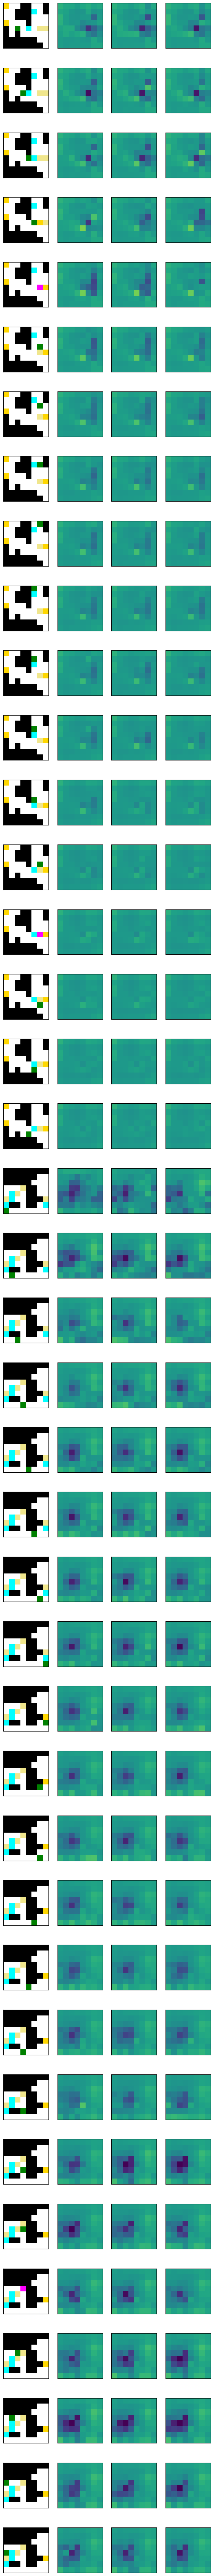

In [32]:
ep_len = 40
ep_start = 160
layer = 0
channel = 30
fig, axs = plt.subplots(ep_len, 4, figsize=(8,ep_len*2.5))

vmin = -1
vmax = 1

for k in range(ep_len):
    trans = val_data[ep_start+k]
    state = trans["board_state"]
    if state.shape[0] != state.shape[1]:
        state = state.permute(1,2,0)
    dim_z = 7
    mini_board = np.zeros(state.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    axs[k][0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[k][0].axes.get_yaxis().set_visible(False)
    axs[k][0].axes.get_xaxis().set_visible(False)
    axs[k][1].imshow(trans["hidden_states"][1,64*layer+32+channel,:,:], vmin=vmin,vmax=vmax)
    axs[k][1].axes.get_yaxis().set_visible(False)
    axs[k][1].axes.get_xaxis().set_visible(False)
    axs[k][2].imshow(trans["hidden_states"][2,64*layer+32+channel,:,:], vmin=vmin,vmax=vmax)
    axs[k][2].axes.get_yaxis().set_visible(False)
    axs[k][2].axes.get_xaxis().set_visible(False)
    axs[k][3].imshow(trans["hidden_states"][3,64*layer+32+channel,:,:], vmin=vmin,vmax=vmax)
    axs[k][3].axes.get_yaxis().set_visible(False)
    axs[k][3].axes.get_xaxis().set_visible(False)

In [ ]:
# PLAN WEIGHTS
weight0 = torch.tensor([[-0.6837276816368103, 0.08642134815454483, 2.5258469581604004, -0.4921751320362091, 1.2463593482971191, -0.9867230653762817, 0.04729536920785904, 0.28849849104881287, -0.36138322949409485,
-0.07113686203956604, 0.845041811466217, 0.5488023161888123, -0.7671644687652588, -0.9444531798362732, 0.32021957635879517, -0.4225016236305237, -0.5519166588783264, -0.18044862151145935,
-0.07549270242452621, -0.24302361905574799, 1.2557265758514404, -0.30061808228492737, -2.907780885696411, 0.8218410611152649, 0.4042874872684479, 1.6314572095870972, 0.01599644124507904,
-0.5025864243507385, -0.13576439023017883, 0.030720066279172897, 0.9375211000442505, -0.764415442943573], 
[0.6836835145950317, 0.10610787570476532, -2.771732807159424, 0.5924633741378784, -1.0194385051727295, 1.1957374811172485, -0.3550739586353302, -0.49757081270217896, 0.2513337731361389, 0.18318021297454834,
-0.7606615424156189, -0.6022713780403137, 0.5610904693603516, 1.1221269369125366, -0.5702047944068909, 0.3721276819705963, 0.3870593309402466, 0.1603395789861679, 0.32394319772720337, 
0.08686233311891556, -1.2280259132385254, 0.018737254664301872, 3.1480674743652344, -0.7804999351501465, -0.47075358033180237, -1.657581090927124, -0.2025476098060608, 0.7297380566596985,
    0.02321203611791134, -0.038493599742650986, -0.8022414445877075, 0.9820601940155029]])

weight1 = torch.tensor([[-0.3309761583805084, 1.531782627105713, 1.3465176820755005, -0.19540958106517792, 1.6348158121109009, 0.11338530480861664, 0.8540199398994446, -0.6451936364173889, 0.7114246487617493,
0.18536025285720825, -1.0371973514556885, -0.9517309665679932, 0.4352772831916809, -0.14601603150367737, -0.39273589849472046, -0.19588740170001984, -0.35819610953330994, 0.43284204602241516,
    0.19508232176303864, -0.42335090041160583, -1.8579126596450806, -0.24377398192882538, 0.534830629825592, 0.5655252933502197, 0.34142738580703735, -0.32439976930618286, -0.22047798335552216,
    2.4178175926208496, 0.7043865323066711, -0.11321786046028137, 0.32928624749183655, 0.3327062129974365], 
    [0.511059582233429, -1.6108510494232178, -1.2262520790100098, 0.012695379555225372, -1.6715184450149536, -0.06787911802530289, -0.6515945792198181, 0.6064745187759399, -0.5865893363952637, 
    -0.049905773252248764, 0.9452276229858398, 1.043906569480896, -0.21981965005397797, -0.013025883585214615, 0.5620828866958618, 0.18030057847499847, 0.2156665027141571, -0.15766671299934387, 
    -0.09356295317411423, 0.23489437997341156, 2.0007996559143066, 0.20852892100811005, -0.46883001923561096, -0.7459681034088135, -0.25280988216400146, 0.4206063449382782, 0.3014945685863495, 
    -2.437561273574829, -0.594936728477478, 0.24333608150482178, -0.3691480755805969, -0.30693021416664124]])

weight2 = torch.tensor([[-0.48737913370132446, 2.0204238891601562, -0.20710276067256927, -0.1559930294752121, -1.4778072834014893, 1.0226231813430786, -0.011008787900209427, 0.26454436779022217,
                            0.5662028789520264, 0.826072633266449, 0.7518832087516785, 0.4854520261287689, -0.545423686504364, -0.1605425626039505, -2.30305552482605, 0.10711660981178284,
                            -0.20925910770893097, -0.4371994435787201, -0.09227673709392548, 0.2594224214553833, 0.09071329236030579, -0.10446739196777344, -0.008032598532736301, -0.6721022725105286, 
                            0.14969028532505035, -0.5917406678199768, 0.7830581068992615, -0.018811164423823357, 0.2390570491552353, 0.2955656945705414, -1.1725964546203613, 0.9227076768875122],
                                [0.6500030755996704, -1.9482715129852295, 0.21371221542358398, -0.007815630175173283, 1.2696133852005005, -0.7610629200935364, 0.0742838978767395, -0.525004506111145, 
                                -0.3204478919506073, -0.8447422981262207, -0.5190479755401611, -0.7739930152893066, 0.6830257177352905, 0.15014739334583282, 2.5916659832000732, -0.32344695925712585, 
                                0.09805583208799362, 0.6653913259506226, 0.010809963569045067, -0.0951007530093193, 0.04532609134912491, -0.021794166415929794, 0.18280953168869019, 0.7764242887496948, 
                                -0.0533781498670578, 0.40867361426353455, -0.7241909503936768, 0.18064184486865997, -0.30017533898353577, -0.36463192105293274, 1.2368476390838623, -0.9249445199966431]])

In [51]:
feature = "tracked_box_loc_change_with_action_1_future_trajectory_120"
results = pd.read_csv(f"./convresults/{feature}.csv", index_col=0)
weight0 = torch.tensor(ast.literal_eval(results.iloc[-1,0]))
weight1 = torch.tensor(ast.literal_eval(results.iloc[-1,1]))
weight2 = torch.tensor(ast.literal_eval(results.iloc[-1,2]))

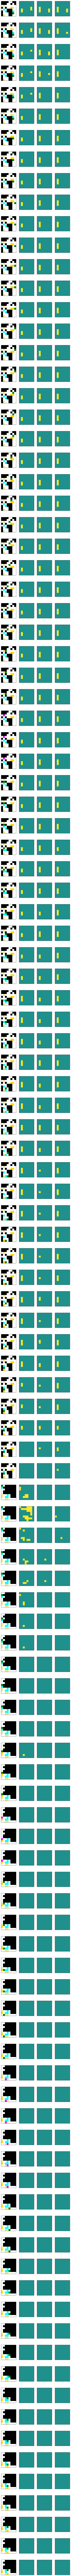

In [53]:
ep_len = 40
ep_start = 70
channels = list(range(32))
fig, axs = plt.subplots(3*ep_len, 4, figsize=(8,ep_len*7.5))

for k in range(ep_len):
    trans = val_data[ep_start+k]
    state = trans["board_state"]
    if state.shape[0] != state.shape[1]:
        state = state.permute(1,2,0)
    dim_z = 7
    mini_board = np.zeros(state.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    map0 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map0[0] += trans["hidden_states"][1,32+channels[j],:,:] * weight0[0,j]
        map0[1] += trans["hidden_states"][1,32+channels[j],:,:] * weight0[1,j]
    map1 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map1[0] += trans["hidden_states"][1,96+channels[j],:,:] * weight1[0,j]
        map1[1] += trans["hidden_states"][1,96+channels[j],:,:] * weight1[1,j]
    map2 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map2[0] += trans["hidden_states"][1,160+channels[j],:,:] * weight2[0,j]
        map2[1] += trans["hidden_states"][1,160+channels[j],:,:] * weight2[1,j]
    axs[3*k][0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[3*k][0].axes.get_yaxis().set_visible(False)
    axs[3*k][0].axes.get_xaxis().set_visible(False)
    axs[3*k][1].imshow(map0.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k][1].axes.get_yaxis().set_visible(False)
    axs[3*k][1].axes.get_xaxis().set_visible(False)
    axs[3*k][2].imshow(map1.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k][2].axes.get_yaxis().set_visible(False)
    axs[3*k][2].axes.get_xaxis().set_visible(False)
    axs[3*k][3].imshow(map2.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k][3].axes.get_yaxis().set_visible(False)
    axs[3*k][3].axes.get_xaxis().set_visible(False)

    map0 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map0[0] += trans["hidden_states"][2,32+channels[j],:,:] * weight0[0,j]
        map0[1] += trans["hidden_states"][2,32+channels[j],:,:] * weight0[1,j]
    map1 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map1[0] += trans["hidden_states"][2,96+channels[j],:,:] * weight1[0,j]
        map1[1] += trans["hidden_states"][2,96+channels[j],:,:] * weight1[1,j]
    map2 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map2[0] += trans["hidden_states"][2,160+channels[j],:,:] * weight2[0,j]
        map2[1] += trans["hidden_states"][2,160+channels[j],:,:] * weight2[1,j]
    axs[3*k+1][0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[3*k+1][0].axes.get_yaxis().set_visible(False)
    axs[3*k+1][0].axes.get_xaxis().set_visible(False)
    axs[3*k+1][1].imshow(map0.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k+1][1].axes.get_yaxis().set_visible(False)
    axs[3*k+1][1].axes.get_xaxis().set_visible(False)
    axs[3*k+1][2].imshow(map1.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k+1][2].axes.get_yaxis().set_visible(False)
    axs[3*k+1][2].axes.get_xaxis().set_visible(False)
    axs[3*k+1][3].imshow(map2.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k+1][3].axes.get_yaxis().set_visible(False)
    axs[3*k+1][3].axes.get_xaxis().set_visible(False)

    map0 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map0[0] += trans["hidden_states"][3,32+channels[j],:,:] * weight0[0,j]
        map0[1] += trans["hidden_states"][3,32+channels[j],:,:] * weight0[1,j]
    map1 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map1[0] += trans["hidden_states"][3,96+channels[j],:,:] * weight1[0,j]
        map1[1] += trans["hidden_states"][3,96+channels[j],:,:] * weight1[1,j]
    map2 = torch.zeros(size=(2,8,8))
    for j in range(len(channels)):
        map2[0] += trans["hidden_states"][3,160+channels[j],:,:] * weight2[0,j]
        map2[1] += trans["hidden_states"][3,160+channels[j],:,:] * weight2[1,j]
    axs[3*k+2][0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[3*k+2][0].axes.get_yaxis().set_visible(False)
    axs[3*k+2][0].axes.get_xaxis().set_visible(False)
    axs[3*k+2][1].imshow(map0.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k+2][1].axes.get_yaxis().set_visible(False)
    axs[3*k+2][1].axes.get_xaxis().set_visible(False)
    axs[3*k+2][2].imshow(map1.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k+2][2].axes.get_yaxis().set_visible(False)
    axs[3*k+2][2].axes.get_xaxis().set_visible(False)
    axs[3*k+2][3].imshow(map2.argmax(dim=0), vmin=-1,vmax=1)
    axs[3*k+2][3].axes.get_yaxis().set_visible(False)
    axs[3*k+2][3].axes.get_xaxis().set_visible(False)
    

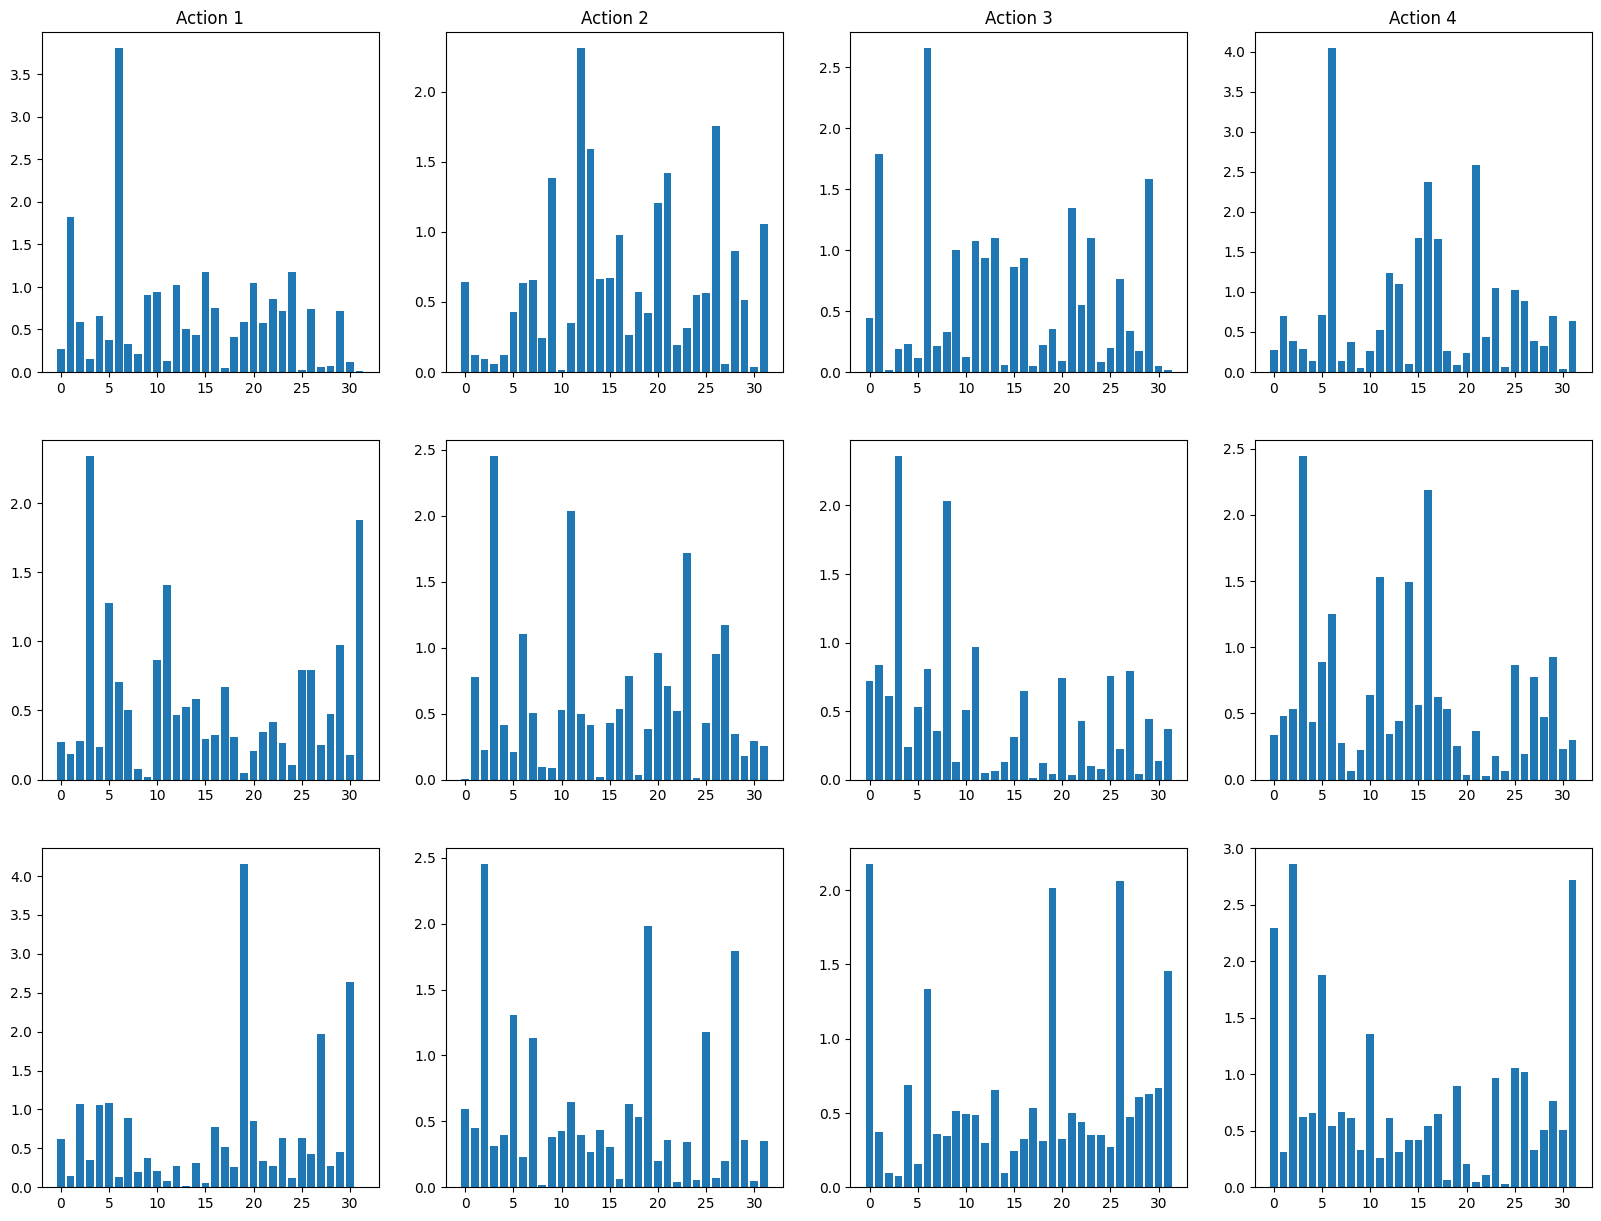

In [67]:
fig, axs = plt.subplots(3,4, figsize=(20,15))
for i in [1,2,3,4]:
    feature = f"tracked_box_loc_change_with_action_{i}_future_trajectory_120"
    results = pd.read_csv(f"./convresults/{feature}.csv", index_col=0)
    weight0 = torch.tensor(ast.literal_eval(results.iloc[-1,0]))
    weight1 = torch.tensor(ast.literal_eval(results.iloc[-1,1]))
    weight2 = torch.tensor(ast.literal_eval(results.iloc[-1,2]))
    axs[0][i-1].bar(x=list(range(32)), height=[abs(c) for c in weight0[1]])
    axs[0][i-1].set_title(f"Action {i}")
    axs[1][i-1].bar(x=list(range(32)), height=[abs(c) for c in weight1[1]])
    axs[2][i-1].bar(x=list(range(32)), height=[abs(c) for c in weight2[1]])

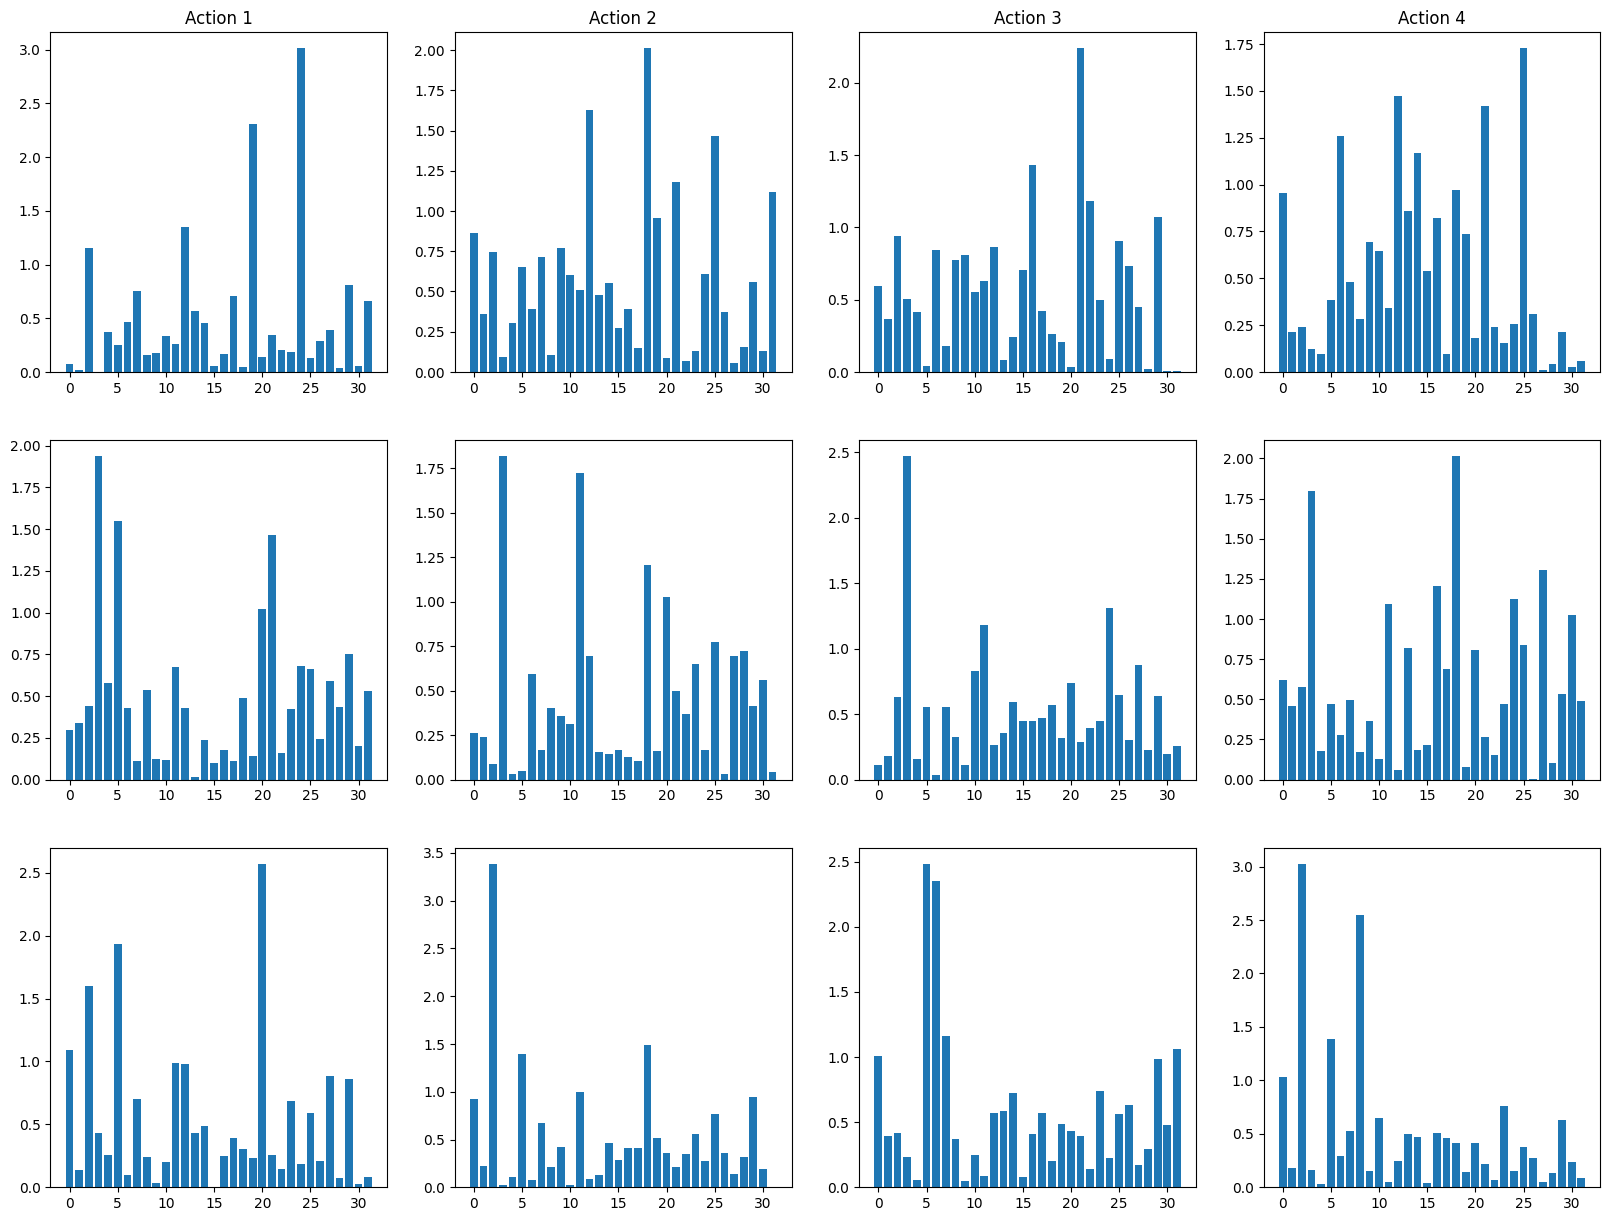

In [68]:
fig, axs = plt.subplots(3,4, figsize=(20,15))
for i in [1,2,3,4]:
    feature = f"tracked_box_loc_change_after_action_{i}_future_trajectory_120"
    results = pd.read_csv(f"./convresults/{feature}.csv", index_col=0)
    weight0 = torch.tensor(ast.literal_eval(results.iloc[-1,1]))
    weight1 = torch.tensor(ast.literal_eval(results.iloc[-1,2]))
    weight2 = torch.tensor(ast.literal_eval(results.iloc[-1,3]))
    axs[0][i-1].bar(x=list(range(32)), height=[abs(c) for c in weight0[1]])
    axs[0][i-1].set_title(f"Action {i}")
    axs[1][i-1].bar(x=list(range(32)), height=[abs(c) for c in weight1[1]])
    axs[2][i-1].bar(x=list(range(32)), height=[abs(c) for c in weight2[1]])

In [36]:
def make_plan_gif(episode_entry, gif_file=".", gif_name="test"):
    weight = torch.tensor([[-0.48737913370132446, 2.0204238891601562, -0.20710276067256927, -0.1559930294752121, -1.4778072834014893, 1.0226231813430786, -0.011008787900209427, 0.26454436779022217, 0.5662028789520264, 0.826072633266449, 0.7518832087516785, 0.4854520261287689, -0.545423686504364, -0.1605425626039505, -2.30305552482605, 0.10711660981178284, -0.20925910770893097, -0.4371994435787201, -0.09227673709392548, 0.2594224214553833, 0.09071329236030579, -0.10446739196777344, -0.008032598532736301, -0.6721022725105286, 0.14969028532505035, -0.5917406678199768, 0.7830581068992615, -0.018811164423823357, 0.2390570491552353, 0.2955656945705414, -1.1725964546203613, 0.9227076768875122], [0.6500030755996704, -1.9482715129852295, 0.21371221542358398, -0.007815630175173283, 1.2696133852005005, -0.7610629200935364, 0.0742838978767395, -0.525004506111145, -0.3204478919506073, -0.8447422981262207, -0.5190479755401611, -0.7739930152893066, 0.6830257177352905, 0.15014739334583282, 2.5916659832000732, -0.32344695925712585, 0.09805583208799362, 0.6653913259506226, 0.010809963569045067, -0.0951007530093193, 0.04532609134912491, -0.021794166415929794, 0.18280953168869019, 0.7764242887496948, -0.0533781498670578, 0.40867361426353455, -0.7241909503936768, 0.18064184486865997, -0.30017533898353577, -0.36463192105293274, 1.2368476390838623, -0.9249445199966431]])
    channels = list(range(32))
    fig, axs = plt.subplots(1,2)
    camera = Camera(fig)
    for trans_idx, trans in enumerate(episode_entry):
        for tick_idx in range(1,4):
            map = torch.zeros(size=(2,8,8))
            for i in range(len(channels)):
                map[0] += trans["hidden_states"][tick_idx,160+channels[i],:,:] * weight[0,i]
                map[1] += trans["hidden_states"][tick_idx,160+channels[i],:,:] * weight[1,i]
            state = trans["board_state"]
            if state.shape[0] != state.shape[1]:
                state = state.permute(1,2,0)
            dim_z = 7
            mini_board = np.zeros(state.shape[:-1])
            for i in range(1,1+dim_z):
                mini_board[(state[:,:,i-1] == 1)] = i
            mini_board = np.flip(mini_board, axis=0)
            cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
            bounds= [i+0.5 for i in range(1+dim_z)]
            norm = colors.BoundaryNorm(bounds, cmap.N)
            axs[0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
            axs[0].axes.get_yaxis().set_visible(False)
            axs[0].axes.get_xaxis().set_visible(False)
            axs[0].text(0.3, 1.01, f'transition {trans_idx+1}', transform=axs[0].transAxes)
            axs[1].imshow(map.argmax(dim=0), vmin=-1,vmax=1)
            axs[1].axes.get_yaxis().set_visible(False)
            axs[1].axes.get_xaxis().set_visible(False)
            axs[1].text(0.4, 1.01, f'tick {tick_idx}', transform=axs[1].transAxes)
            plt.pause(0.1)
            camera.snap()
    animation = camera.animate()
    animation.save(f"{gif_file}/{gif_name}.gif", writer='PillowWriter', fps=1)

def make_comp_plan_gif(episode_entry_1, episode_entry_2, gif_file=".", gif_name="test"):
    weight = torch.tensor([[ 1.4671,  0.1764, -1.6669, -0.3345, -0.0650,  0.3685, -0.0773, -1.6445,
          0.5012, -1.0107,  0.5285, -0.6314, -0.2354, -0.6516,  1.1393, -0.2536,
         -0.2376, -0.7812,  0.3451,  0.2675,  0.6425, -0.1733,  0.1367,  0.8513,
         -0.0975, -0.7932, -0.0480, -0.0213,  0.0230,  0.0217,  0.5805,  0.1462],
        [-1.5457, -0.2613,  1.7168,  0.4978, -0.0358, -0.1685,  0.1296,  1.3273,
         -0.5445,  1.0075, -0.3762,  0.8008,  0.3089,  0.6018, -1.1386,  0.2614,
          0.2385,  0.7087, -0.4600, -0.3193, -0.6130,  0.1986,  0.0698, -0.8983,
          0.1402,  0.5620,  0.2461,  0.0548, -0.1813, -0.0444, -0.8249, -0.2564]])
    channels = list(range(32))
    fig, axs = plt.subplots(2,2)
    camera = Camera(fig)
    for trans_idx in range(len(episode_entry_1)):
        for tick_idx in range(1,4):
            map1 = torch.zeros(size=(2,8,8))
            for i in range(len(channels)):
                map1[0] += episode_entry_1[trans_idx]["hidden_states"][tick_idx,160+channels[i],:,:] * weight[0,i]
                map1[1] += episode_entry_1[trans_idx]["hidden_states"][tick_idx,160+channels[i],:,:] * weight[1,i]
            state1 = episode_entry_1[trans_idx]["board_state"]
            if state1.shape[0] != state1.shape[1]:
                state1 = state1.permute(1,2,0)
            dim_z = 7
            mini_board1 = np.zeros(state1.shape[:-1])
            for i in range(1,1+dim_z):
                mini_board1[(state1[:,:,i-1] == 1)] = i
            mini_board1 = np.flip(mini_board1, axis=0)
            cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
            bounds= [i+0.5 for i in range(1+dim_z)]
            norm = colors.BoundaryNorm(bounds, cmap.N)
            axs[0][0].imshow(mini_board1, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
            axs[0][0].axes.get_yaxis().set_visible(False)
            axs[0][0].axes.get_xaxis().set_visible(False)
            axs[0][0].text(0.3, 1.01, f'transition {trans_idx+1}', transform=axs[0][0].transAxes)
            axs[0][1].imshow(map1.argmax(dim=0), vmin=-1,vmax=1)
            axs[0][1].axes.get_yaxis().set_visible(False)
            axs[0][1].axes.get_xaxis().set_visible(False)
            axs[0][1].text(0.4, 1.01, f'tick {tick_idx}', transform=axs[0][1].transAxes)

            map2 = torch.zeros(size=(2,8,8))
            for i in range(len(channels)):
                map2[0] += episode_entry_2[trans_idx]["hidden_states"][tick_idx,160+channels[i],:,:] * weight[0,i]
                map2[1] += episode_entry_2[trans_idx]["hidden_states"][tick_idx,160+channels[i],:,:] * weight[1,i]
            state2 = episode_entry_2[trans_idx]["board_state"]
            if state2.shape[0] != state2.shape[1]:
                state2 = state2.permute(1,2,0)
            dim_z = 7
            mini_board2 = np.zeros(state2.shape[:-1])
            for i in range(1,1+dim_z):
                mini_board2[(state2[:,:,i-1] == 1)] = i
            mini_board2 = np.flip(mini_board2, axis=0)
            cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
            bounds= [i+0.5 for i in range(1+dim_z)]
            norm = colors.BoundaryNorm(bounds, cmap.N)
            axs[1][0].imshow(mini_board2, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
            axs[1][0].axes.get_yaxis().set_visible(False)
            axs[1][0].axes.get_xaxis().set_visible(False)
            axs[1][1].imshow(map2.argmax(dim=0), vmin=-1,vmax=1)
            axs[1][1].axes.get_yaxis().set_visible(False)
            axs[1][1].axes.get_xaxis().set_visible(False)
            plt.pause(0.1)
            camera.snap()
    animation = camera.animate()
    animation.save(f"{gif_file}/{gif_name}.gif", writer='PillowWriter', fps=1)

In [9]:
val_data[0]

{'adj_walls': 0,
 'adj_boxnotontar': 0,
 'adj_boxontar': 0,
 'adj_box': 0,
 'adj_tar': 0,
 'num_boxnotontar': 4,
 'agent_loc': (7,),
 'box_loc': (13, 14, 22, 38),
 'tar_loc': (28, 29, 36, 45),
 'boxontar_loc': (),
 'boxnotontar_loc': (13, 14, 22, 38),
 'justtar_loc': (28, 29, 36, 45),
 'action': 3,
 'value': 5.743,
 'board_state': tensor([[[1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1]],
 
         [[0, 0, 0, 1, 1, 1, 1, 0],
          [0, 0, 0, 1, 1, 0, 0, 1],
          [0, 0, 0, 0, 0, 1, 0, 1],
          [0, 0, 0, 0, 0, 0, 1, 1],
          [0, 0, 1, 1, 0, 1, 0, 1],
          [0, 0, 1, 1, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 1, 0],
          [0, 

In [47]:
val_data[112]["steps_remaining"]

33

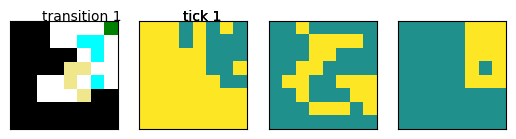

KeyboardInterrupt: 

In [14]:
make_plan_gif_across_layers(val_data[:30])

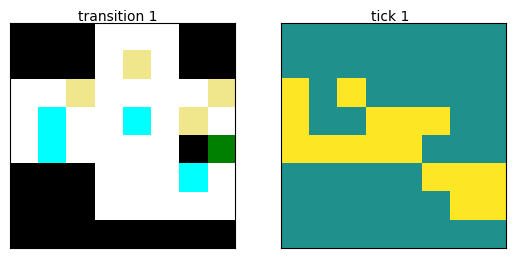

MovieWriter PillowWriter unavailable; using Pillow instead.


In [48]:
make_plan_gif(val_data[112:145], gif_file="./plan_viz", gif_name="val_ep4_plan")

In [27]:
for i, trans in enumerate(val_data[93:113]):
    print(i+1, trans["tar_next_current_0"], "\n\n")

1 tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]) 


2 tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]) 


3 tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]) 


4 tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0

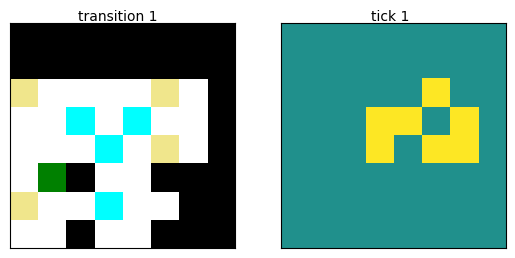

MovieWriter PillowWriter unavailable; using Pillow instead.


In [57]:
make_plan_gif(val_data[439:448])

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


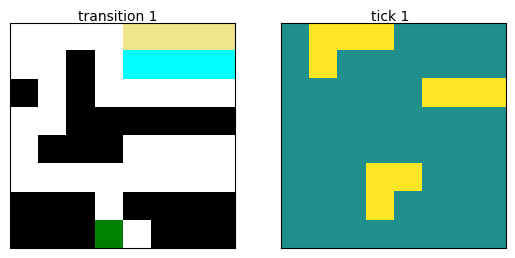

MovieWriter PillowWriter unavailable; using Pillow instead.


In [72]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"shortcutpush_clean_{0:04}"

env = thinker.make(
    f"Sokoban-{envname}-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset()
episode_entry = [] 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
for i in range(6):
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    state, reward, done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, new_rnn_state = drc_net(env_out, rnn_state, greedy=True)
    episode_entry.append({"board_state": state["real_states"][0], "hidden_states": drc_net.hidden_state[0]})
make_plan_gif(episode_entry, gif_file="./plan_viz", gif_name=envname)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


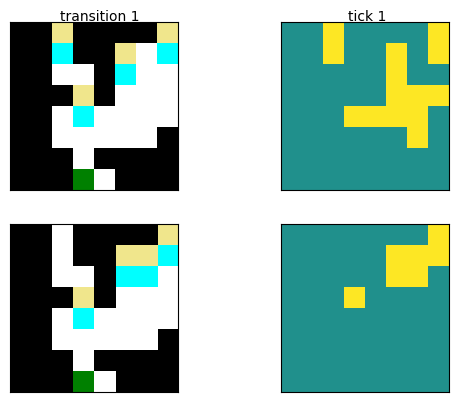

MovieWriter PillowWriter unavailable; using Pillow instead.


In [22]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

env = thinker.make(
    f"Sokoban-cutoffpush_clean_0000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset()
episode_entry_1 = [] 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
for i in range(10):
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    state, reward, done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, new_rnn_state = drc_net(env_out, rnn_state, greedy=True)
    episode_entry_1.append({"board_state": state["real_states"][0], "hidden_states": drc_net.hidden_state[0]})

env = thinker.make(
    f"Sokoban-cutoffpush_corrupt_0000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset()
episode_entry_2 = [] 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
for i in range(10):
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    state, reward, done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, new_rnn_state = drc_net(env_out, rnn_state, greedy=True)
    episode_entry_2.append({"board_state": state["real_states"][0], "hidden_states": drc_net.hidden_state[0]})

make_comp_plan_gif(episode_entry_1, episode_entry_2, gif_file="./plan_viz", gif_name=envname)

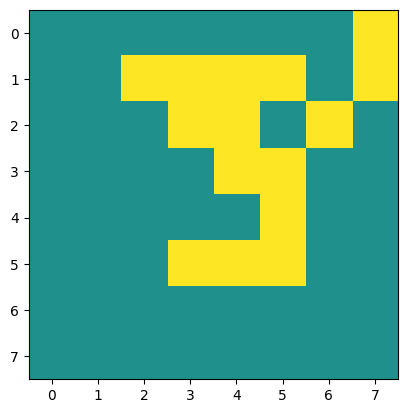

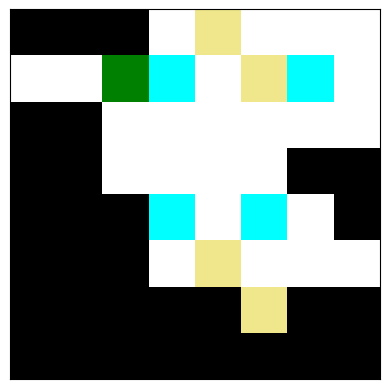

In [44]:
idx = 65
weight = torch.tensor([[ 2.0827, -2.8541, -5.1667, -1.5724, -1.4265],
        [-2.3955,  2.6245,  4.9200,  1.7546,  1.7780]])
channels = [10,13,14,15,16]
map = torch.zeros(size=(2,8,8))
for i in range(len(channels)):
    map[0] += val_data[idx]["hidden_states"][-1,160+channels[i],:,:] * weight[0,i]
    map[1] += val_data[idx]["hidden_states"][-1,160+channels[i],:,:] * weight[1,i]
plt.imshow(map.argmax(dim=0), vmin=-1,vmax=1)
plt.show()
viz.plot_mini_sokoban(val_data[idx]["board_state"])

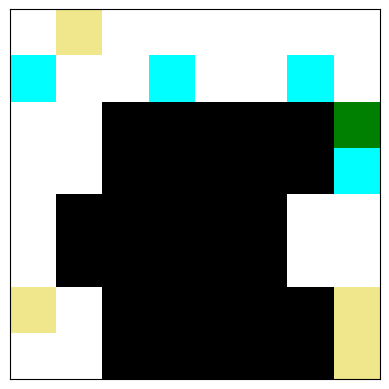

In [8]:
viz.plot_mini_sokoban(val_data[3]["board_state"])

In [2]:
import seaborn as sns

In [54]:
feature = "tracked_box_loc_change_with_action_4_future_trajectory_120"
results = pd.read_csv(f"./convresults/{feature}.csv", index_col=0)

Text(0.5, 1.0, 'tracked_box_loc_change_with_action_4_future_trajectory_120')

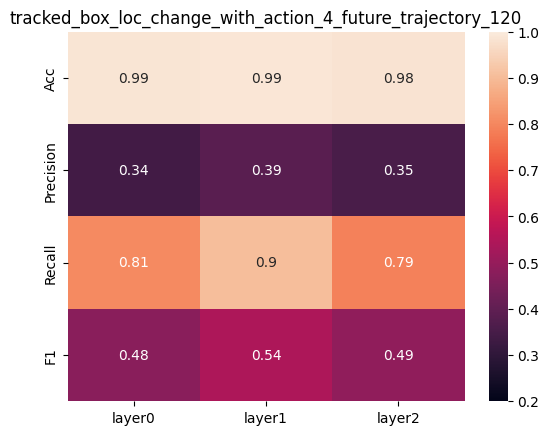

In [55]:
sns.heatmap(results.iloc[:-1,:].astype(float), annot=True, vmin=0.2, vmax=1).set_title(feature)

In [100]:
def get_future_trajectories(episode_entry):
    for trans_idx, trans in enumerate(episode_entry):
        agent_locs_xy = torch.tensor([(trans["agent_loc"][0] % 8, (trans["agent_loc"][0]-(trans["agent_loc"][0]%8))//8) for trans in episode_entry[trans_idx:]])
        trajectory = torch.zeros(size=(8,8))
        trajectory[agent_locs_xy[:,1],agent_locs_xy[:,0]] = 1
        trans["future_trajectory"] = trajectory
    return episode_entry

In [98]:
ep1_data = get_future_trajectories(val_data[:23])

In [42]:
agent_locs = [trans["agent_loc"][0] for trans in ep1_data]
agent_locs_xy = torch.tensor([(trans["agent_loc"][0] % 8, (trans["agent_loc"][0]-(trans["agent_loc"][0]%8))//8) for trans in ep1_data])

In [64]:
target = torch.zeros(size=(8,8))
target[agent_locs_xy[:,0],agent_locs_xy[:,1]] = 1
target = target.unsqueeze(0)

In [56]:
conv = torch.nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1, bias=False)

In [57]:
input = ep1_data[0]["hidden_states"][[-1],160:192,:,:]

In [59]:
out = conv(input)

In [61]:
out[0,0,0,0], out[0,0,0,1], out[0,0,0,2] 

(tensor(0.3426, grad_fn=<SelectBackward0>),
 tensor(0.4377, grad_fn=<SelectBackward0>),
 tensor(0.4511, grad_fn=<SelectBackward0>))

In [80]:
out, target = out.view(1,2,-1), target.view(1,-1).to(torch.long)

In [81]:
loss = nn.CrossEntropyLoss()
loss(out, target)

tensor(0.5804, grad_fn=<NllLoss2DBackward0>)

In [116]:
class ConvProbe(nn.Module):
    def __init__(self, in_channels, out_dim, kernel_size):
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_dim, kernel_size=kernel_size, bias=False)
        self.out_dim = out_dim
        self.loss_fnc = nn.CrossEntropyLoss()
    def forward(self, input, targets=None):
        out = self.conv(input)
        if targets:
            assert out.shape[0] == targets.shape[0]
            out = out.view(out.shape[0], self.out_dim, 64)
            targets = targets.view(out.shape[0], 64)
            loss = self.loss_fnc(out, targets)
        else:
            loss = None
        return out, loss

In [19]:

for i in range(len(val_data)):
    if val_data[i]["board_num"] == 1:
        print(val_data[i]["box_loc"], val_data[i]["box_loc_change_loc"])

(28, 49, 50, 51) 49
(28, 49, 50, 51) 49
(28, 49, 50, 51) 49
(28, 49, 50, 51) 49
(28, 49, 50, 51) 49
(28, 49, 50, 51) 49
(28, 42, 49, 51) 42
(28, 34, 49, 51) 49
(28, 34, 49, 51) 49
(28, 34, 48, 51) 48
(28, 34, 48, 51) 48
(28, 34, 48, 51) 48
(28, 34, 40, 51) 40
(28, 32, 34, 51) 28
(24, 28, 34, 51) 24
(16, 28, 34, 51) 51
(16, 28, 34, 51) 51
(16, 28, 34, 51) 51
(16, 28, 34, 51) 51
(16, 28, 34, 51) 51
(16, 28, 34, 51) 51
(16, 28, 34, 51) 51
(16, 28, 34, 51) 51
(16, 28, 34, 43) 43
(16, 28, 34, 35) 34
(16, 27, 28, 34) 27
(16, 19, 28, 34) 28
(16, 19, 29, 34) 28
(16, 19, 29, 34) 28
(16, 19, 29, 34) 28
(16, 19, 29, 33) 28


In [2]:
results = pd.read_csv("./results/manyfeat_multi_random.csv")

In [10]:
results

,Unnamed: 0,agent_loc_ahead_1_linear_layer0_channelcell_tick3,agent_loc_ahead_1_linear_layer1_channelcell_tick3,agent_loc_ahead_1_linear_layer2_channelcell_tick3,agent_loc_ahead_2_linear_layer0_channelcell_tick3,agent_loc_ahead_2_linear_layer1_channelcell_tick3,agent_loc_ahead_2_linear_layer2_channelcell_tick3,agent_loc_ahead_3_linear_layer0_channelcell_tick3,agent_loc_ahead_3_linear_layer1_channelcell_tick3,agent_loc_ahead_3_linear_layer2_channelcell_tick3,...,action_ahead_4_linear_layer2_channelcell_tick3,action_ahead_5_linear_layer0_channelcell_tick3,action_ahead_5_linear_layer1_channelcell_tick3,action_ahead_5_linear_layer2_channelcell_tick3,action_ahead_6_linear_layer0_channelcell_tick3,action_ahead_6_linear_layer1_channelcell_tick3,action_ahead_6_linear_layer2_channelcell_tick3,action_ahead_7_linear_layer0_channelcell_tick3,action_ahead_7_linear_layer1_channelcell_tick3,action_ahead_7_linear_layer2_channelcell_tick3
0,train_loss,3.226747,3.479313,3.226443,3.318688,3.492396,3.231720,3.424727,3.639157,3.302157,...,1.242534,1.252789,1.270747,1.260787,1.259708,1.283284,1.259037,1.263105,1.288799,1.264316
1,val_loss,3.457652,3.759618,3.336628,3.701747,3.851488,3.461302,3.879733,3.971571,3.683417,...,1.464274,1.485514,1.485873,1.451983,1.539541,1.542736,1.519723,1.535186,1.527368,1.535190
2,val_acc,0.748921,0.434858,0.854185,0.490893,0.338072,0.735229,0.309199,0.216302,0.512750,...,0.430451,0.414244,0.402132,0.444283,0.349398,0.347390,0.360944,0.362500,0.361979,0.354167
3,test_acc,0.706058,0.436433,0.879693,0.513644,0.333627,0.752201,0.318761,0.214481,0.545993,...,0.414380,0.417319,0.396282,0.433464,0.387487,0.375883,0.374369,0.345912,0.364780,0.349581


In [12]:
results.iloc[:,0][3]

'test_acc'

In [27]:
test_accs, test_labs = [], []
for i in [3,6,9,12,15,18]:
    test_accs.append(results.iloc[:,i+21][3])
    test_labs.append(" ".join(results.iloc[:,i+21].name.split("_")[:4]))

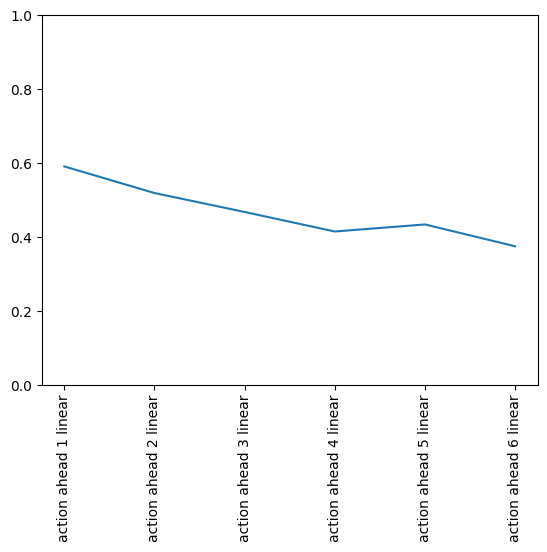

In [28]:
plt.plot(test_accs)
plt.xticks(ticks=range(6), labels=test_labs, rotation="vertical")
plt.ylim(0,1)
plt.show()

In [6]:
results = pd.read_csv("./results/action_multi_random.csv")

In [7]:
weights = [float(s) for s in results["action_linear_layer2_channelhiddenxenc_tick3"][4].strip("[]").split(", ")]

In [51]:
weights = [0.1773, 0.0485, 0.1035, 0.5609, 0.1242, 0.1044, 0.0961, 0.1722, 0.1480,
        0.1609, 0.1480, 0.1818, 0.1854, 0.1300, 0.1218, 0.1099, 0.1905, 0.1437,
        0.1737, 0.0430, 0.1152, 0.4622, 0.6324, 0.1492, 0.3597, 0.1442, 0.5064,
        0.1224, 0.1815, 0.1140, 0.1977, 0.2997]

<BarContainer object of 64 artists>

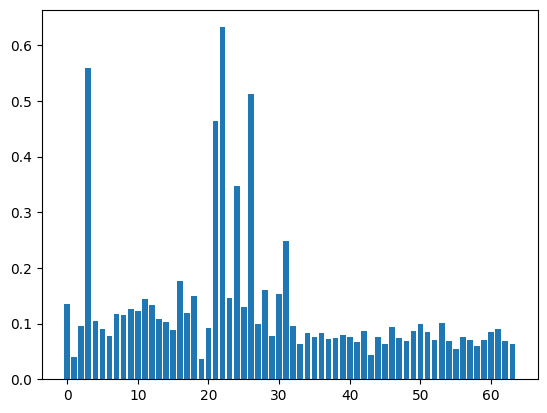

In [8]:
plt.bar(range(64), weights)

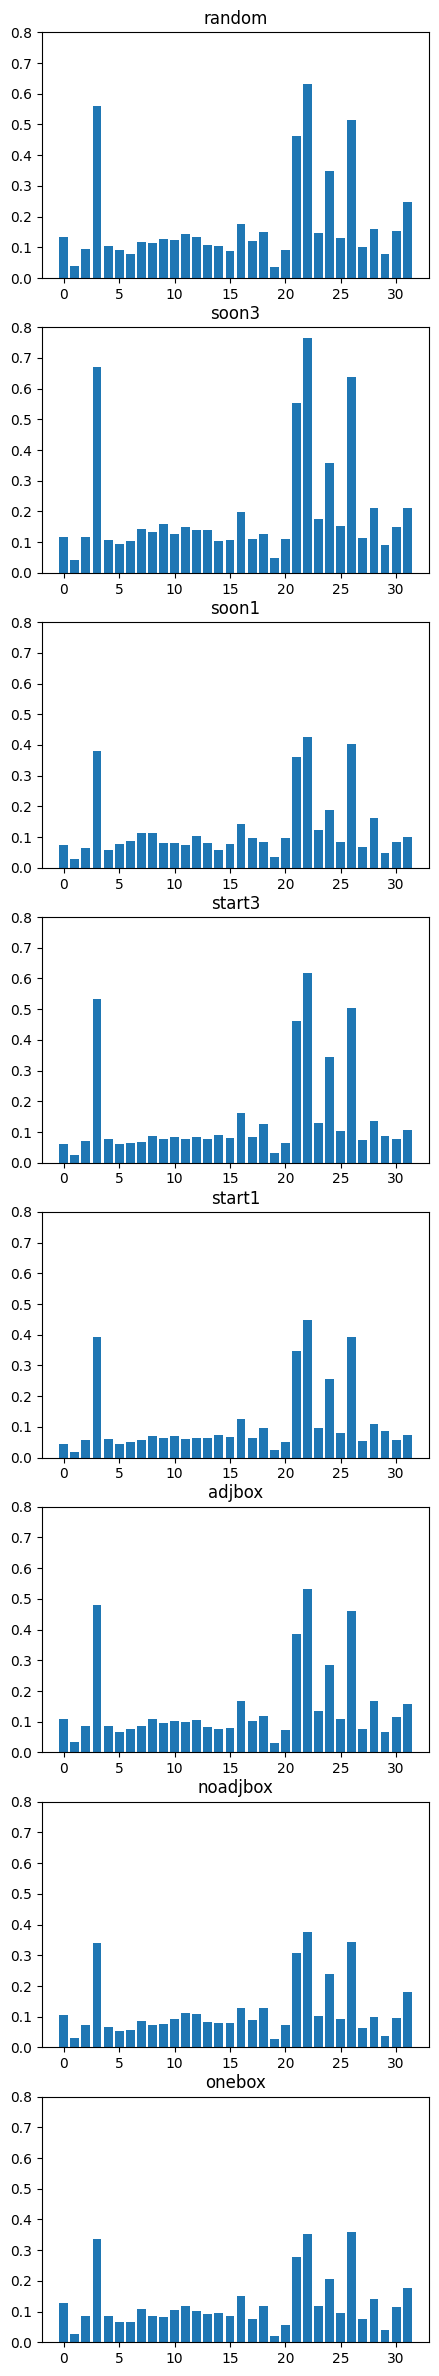

In [36]:
fig, axs = plt.subplots(8,1, figsize=(5,30))
all_weights = np.zeros((8,64))
for idx, subset in enumerate(["random", "soon3", "soon1", "start3", "start1", "adjbox", "noadjbox", "onebox"]):
    results = pd.read_csv(f"./results/action_multi_{subset}.csv")
    weights = [float(s) for s in results["action_linear_layer2_channelhiddenxenc_tick3"][4].strip("[]").split(", ")] 
    all_weights[idx,:] = [s / sum(weights) for s in weights]
    axs[idx].bar(range(32), weights[:32])
    axs[idx].set_title(subset)
    axs[idx].set_ylim(0,0.8)

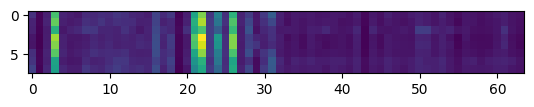

In [37]:
plt.imshow(all_weights)

In [51]:
feature = "action_ahead_1"
results = pd.read_csv(f"./results/{feature}_multi.csv")
test_accs = list(results.iloc[-1,1:].values[-1:]) + list(results.iloc[-1,1:].values[:3]) + list(results.iloc[-1,1:].values[4:6]) + list(results.iloc[-1,1:].values[7:-1])
labs = results.keys().to_list()[1:][:3] + results.keys().to_list()[1:][4:6] + results.keys().to_list()[1:][7:]
fig, ax = plt.subplots()
cols = ["purple"] + ["green"]*3 + ["blue"]*3 + ["red"]*3
labs = ["x_enc", "hidden_0", "cell_0", "hidden+x_enc_0", "hidden_1", "cell_1", "hidden+x_enc_1", "hidden_2", "cell_2", "hidden+x_enc_2"]
ax.bar(labs, test_accs, color=cols)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)
ax.set_ylabel("test acc (%)")
ax.set_title(f"Linear probe: {feature}")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './results/action_ahead_1_multi.csv'

In [6]:
results.iloc[-1,1:]

action_linear_layer2_channel[32]_tick3    0.285714
action_linear_layer2_channel[33]_tick3    0.243386
action_linear_layer2_channel[34]_tick3    0.248677
action_linear_layer2_channel[35]_tick3    0.455026
action_linear_layer2_channel[36]_tick3    0.333333
action_linear_layer2_channel[37]_tick3    0.206349
action_linear_layer2_channel[38]_tick3    0.322751
action_linear_layer2_channel[39]_tick3    0.291005
action_linear_layer2_channel[40]_tick3    0.291005
action_linear_layer2_channel[41]_tick3    0.328042
action_linear_layer2_channel[42]_tick3    0.359788
action_linear_layer2_channel[43]_tick3    0.222222
action_linear_layer2_channel[44]_tick3     0.31746
action_linear_layer2_channel[45]_tick3    0.301587
action_linear_layer2_channel[46]_tick3    0.312169
action_linear_layer2_channel[47]_tick3    0.338624
action_linear_layer2_channel[48]_tick3    0.402116
action_linear_layer2_channel[49]_tick3    0.291005
action_linear_layer2_channel[50]_tick3    0.301587
action_linear_layer2_channel[51

In [9]:
import seaborn as sns

Text(0.5, 1.0, 'agent_loc_future_trajectory_120_50m')

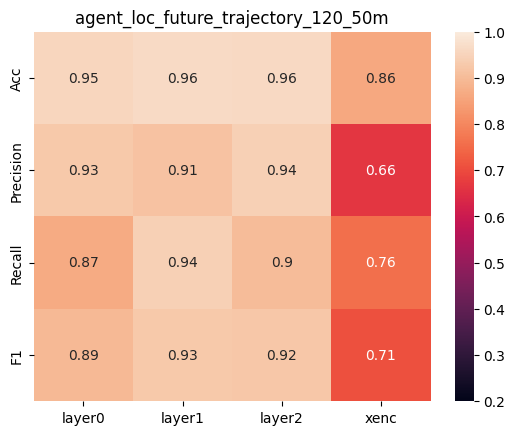

In [50]:
feature = "agent_loc_future_trajectory_120_50m"
results = pd.read_csv(f"./convresults/{feature}", index_col=0)
sns.heatmap(results, annot=True, vmin=0.2, vmax=1).set_title(feature)

In [52]:
rets = [4.4, 10.8, 11.7, 12.3, 12.6]
recs = [0.41, 0.77, 0.85, 0.87, 0.9]
precs = [0.62, 0.84, 0.91, 0.92, 0.94]

Text(0.5, 0, 'avg. ret')

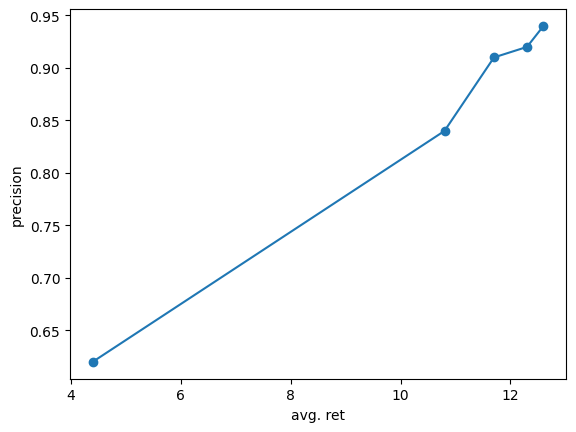

In [62]:
plt.plot(rets,precs, "-o")
plt.ylabel("precision")
plt.xlabel("avg. ret")

Text(0.5, 1.0, 'agent_loc_future_trajectory_120')

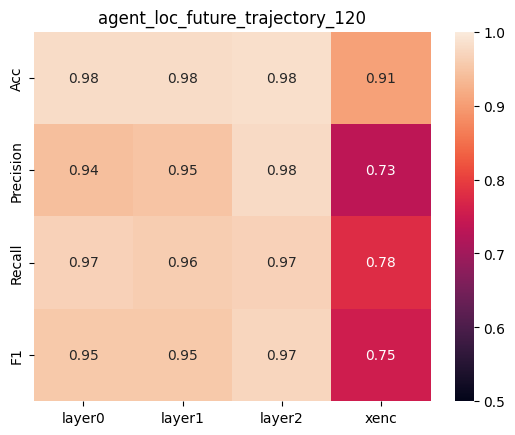

In [13]:
sns.heatmap(results, annot=True, vmin=0.5, vmax=1).set_title(feature)

In [5]:
feature = "action"
results = pd.read_csv(f"./results/{feature}_indiv.csv")
list(results.iloc[-1,1:].values)

[0.2857142857142857,
 0.2433862433862433,
 0.2486772486772486,
 0.455026455026455,
 0.3333333333333333,
 0.2063492063492063,
 0.3227513227513227,
 0.291005291005291,
 0.291005291005291,
 0.328042328042328,
 0.3597883597883597,
 0.2222222222222222,
 0.3174603174603174,
 0.3015873015873015,
 0.3121693121693121,
 0.3386243386243386,
 0.4021164021164021,
 0.291005291005291,
 0.3015873015873015,
 0.2645502645502645,
 0.3174603174603174,
 0.7513227513227513,
 0.7301587301587301,
 0.3809523809523809,
 0.5555555555555556,
 0.2804232804232804,
 0.7777777777777778,
 0.2645502645502645,
 0.4232804232804232,
 0.2222222222222222,
 0.291005291005291,
 0.3121693121693121]

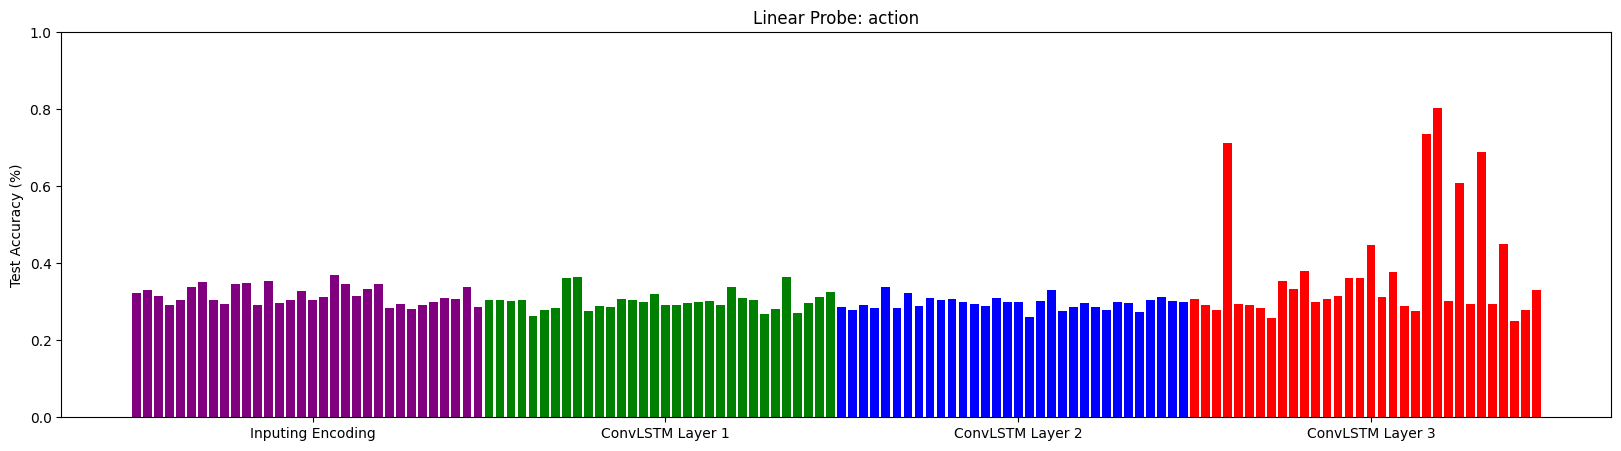

In [42]:
feature = "action"
results = pd.read_csv(f"./results/{feature}_indiv_random.csv")
test_accs = list(results.iloc[-1,1:])
labs = ["_".join(x.split("_")[-3:-1]) for x in results.keys().to_list()[1:]]
fig, ax = plt.subplots(figsize=(20,5))
color = ["purple"]*32 + ["green"]*32 + ["blue"]*32 + ["red"]*32
ax.bar(labs[-32:]+labs[:-32], test_accs[-32:]+test_accs[:-32], color=color)
ax.set_xticks(ticks=[16,48, 80,112], labels=["Inputing Encoding", "ConvLSTM Layer 1", "ConvLSTM Layer 2", "ConvLSTM Layer 3"])
ax.set_ylim(0,1)
ax.set_ylabel("Test Accuracy (%)")
ax.set_title(f"Linear Probe: {feature}")
plt.show()

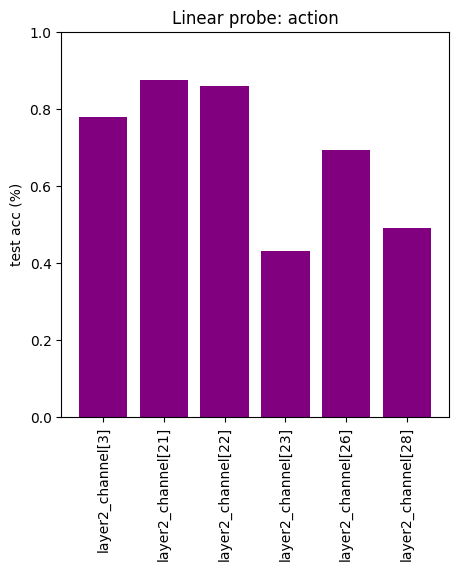

In [10]:
feature = "action"
results = pd.read_csv(f"./results/{feature}_indiv_soon2.csv")
test_accs = list(results.iloc[-1,1:])[-6:]
labs = ["_".join(x.split("_")[-3:-1]) for x in results.keys().to_list()[1:]][-6:]
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(labs, test_accs, color=color)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)
ax.set_ylabel("test acc (%)")
ax.set_title(f"Linear probe: {feature}")
plt.show()

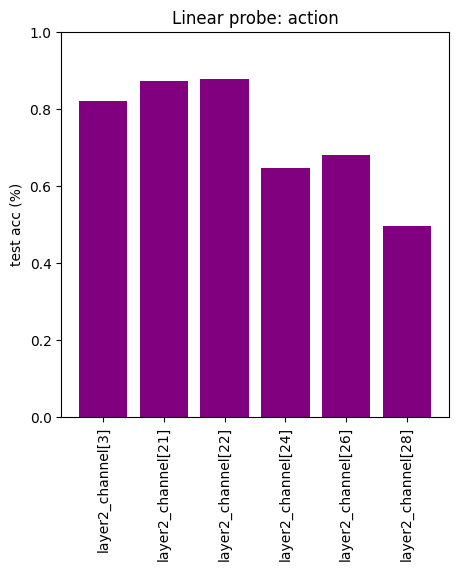

In [16]:
feature = "action"
results = pd.read_csv(f"./results/{feature}_indiv_soon1.csv")
test_accs = list(results.iloc[-1,1:])[-6:]
labs = ["_".join(x.split("_")[-3:-1]) for x in results.keys().to_list()[1:]][-6:]
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(labs, test_accs, color=color)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)
ax.set_ylabel("test acc (%)")
ax.set_title(f"Linear probe: {feature}")
plt.show()

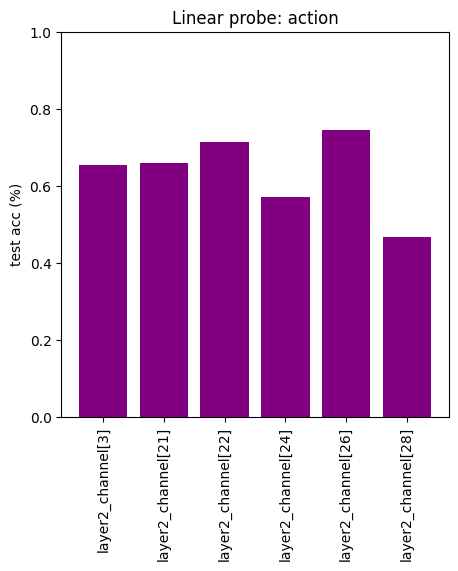

In [13]:
feature = "action"
results = pd.read_csv(f"./results/{feature}_indiv_start1.csv")
test_accs = list(results.iloc[-1,1:])[-6:]
labs = ["_".join(x.split("_")[-3:-1]) for x in results.keys().to_list()[1:]][-6:]
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(labs, test_accs, color=color)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)
ax.set_ylabel("test acc (%)")
ax.set_title(f"Linear probe: {feature}")
plt.show()

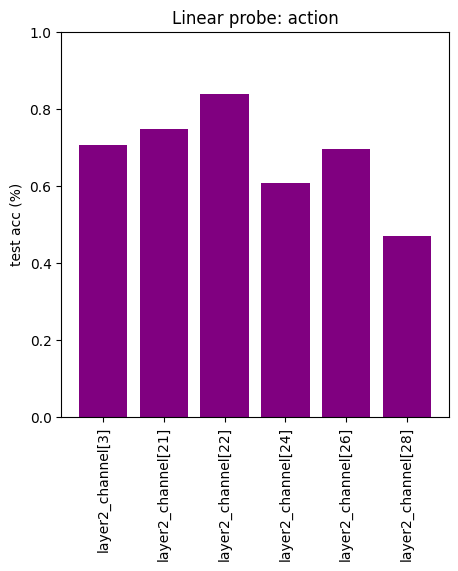

In [17]:
feature = "action"
results = pd.read_csv(f"./results/{feature}_indiv_1onebox.csv")
test_accs = list(results.iloc[-1,1:])[-6:]
labs = ["_".join(x.split("_")[-3:-1]) for x in results.keys().to_list()[1:]][-6:]
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(labs, test_accs, color=color)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)
ax.set_ylabel("test acc (%)")
ax.set_title(f"Linear probe: {feature}")
plt.show()

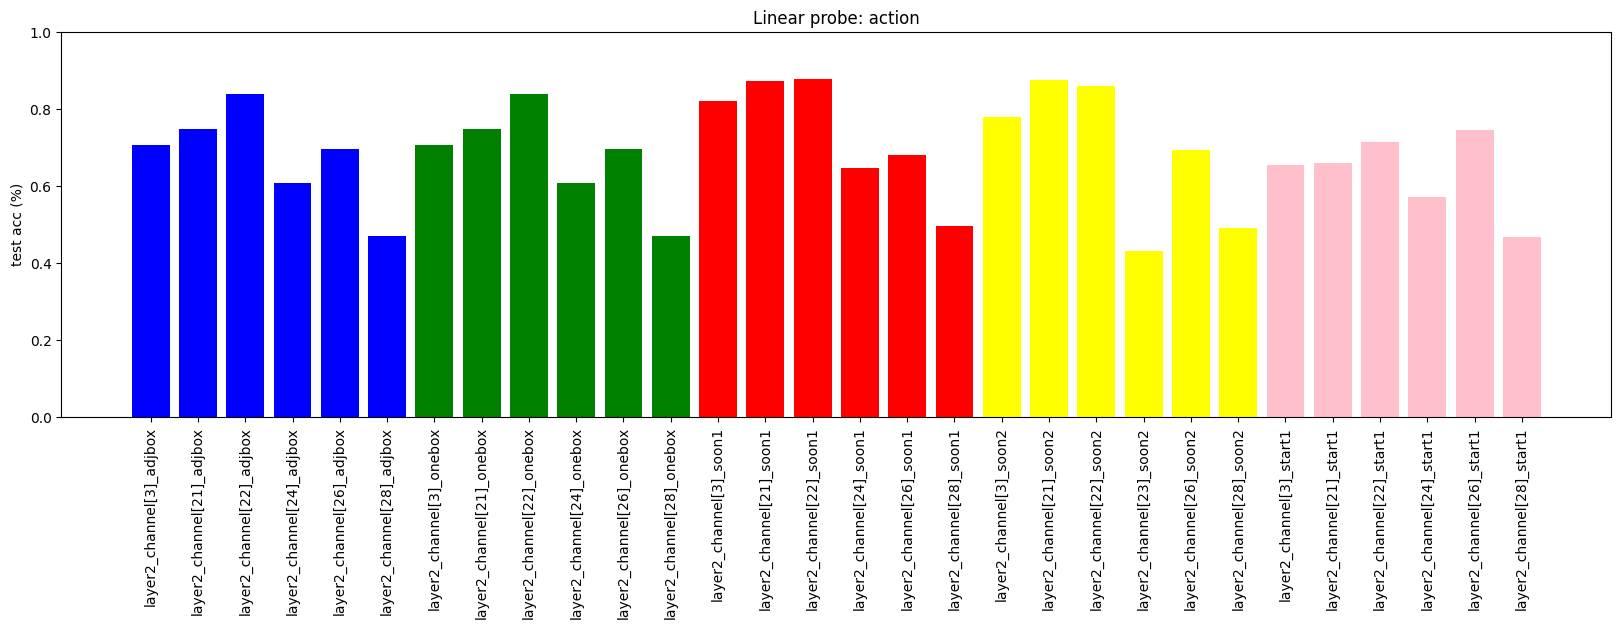

In [8]:
feature = "action"
results = pd.read_csv(f"./results/{feature}_indiv_1adjbox.csv")
test_accs = list(results.iloc[-1,1:])[-6:]
labs = ["_".join(x.split("_")[-3:-1] + ["adjbox"]) for x in results.keys().to_list()[1:]][-6:]
results = pd.read_csv(f"./results/{feature}_indiv_1onebox.csv")
test_accs += list(results.iloc[-1,1:])[-6:]
labs += ["_".join(x.split("_")[-3:-1] + ["onebox"]) for x in results.keys().to_list()[1:]][-6:]
results = pd.read_csv(f"./results/{feature}_indiv_soon1.csv")
test_accs += list(results.iloc[-1,1:])[-6:]
labs += ["_".join(x.split("_")[-3:-1] + ["soon1"]) for x in results.keys().to_list()[1:]][-6:]
results = pd.read_csv(f"./results/{feature}_indiv_soon2.csv")
test_accs += list(results.iloc[-1,1:])[-6:]
labs += ["_".join(x.split("_")[-3:-1] + ["soon2"]) for x in results.keys().to_list()[1:]][-6:]
results = pd.read_csv(f"./results/{feature}_indiv_start1.csv")
test_accs += list(results.iloc[-1,1:])[-6:]
labs += ["_".join(x.split("_")[-3:-1] + ["start1"]) for x in results.keys().to_list()[1:]][-6:]
cols = ["blue"] * 6 + ["green"] * 6 + ["red"] *6 + ["yellow"] * 6 + ["pink"] * 6
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(labs, test_accs, color=cols)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0,1)
ax.set_ylabel("test acc (%)")
ax.set_title(f"Linear probe: {feature}")
plt.show()

In [38]:
results = pd.read_csv("./results/many_multi_random.csv")

In [57]:
maws_str = results.iloc[-1,:][1:].values
maws_arr = np.zeros((7,64))
for i,maws in enumerate(maws_str):
    maws = maws.strip("[]").split(", ")
    maws_arr[i,:] = [float(s) for s in maws]

In [85]:
results.iloc[-2,:][1:].values.tolist()

['0.9517388218594748',
 '0.6695652173913044',
 '0.5501945525291829',
 '1.0',
 '0.9361058601134216',
 '0.8404669260700389',
 '0.6000805477245268']

In [21]:
results = pd.read_csv(f"./results/many_multi_soon3.csv")

In [30]:
[float(c) for c in list(results["agent_loc_linear_layer2_channelhiddenxenc_tick3"][4][:32].strip("[]").split(", "))]

[0.15980005264282227, 1.62138187]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (32,) and arg 1 with shape (2,).

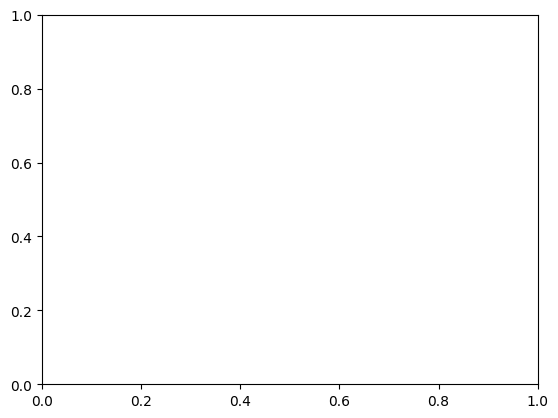

In [29]:
plt.bar(x=range(32), height=[float(c) for c in list(results["agent_loc_linear_layer2_channelhiddenxenc_tick3"][4][:32].strip("[]").split(", "))])

<BarContainer object of 32 artists>

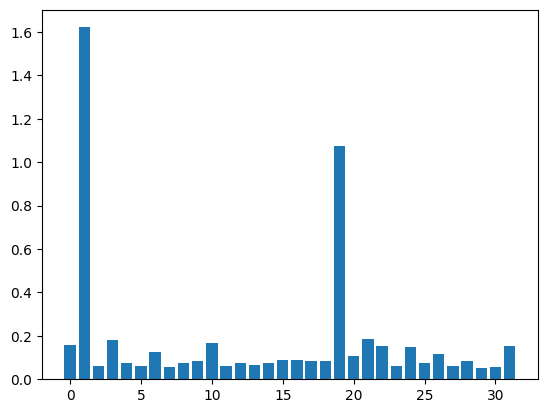

In [37]:
plt.bar(height=maws_arr[3][:32], x=range(32))

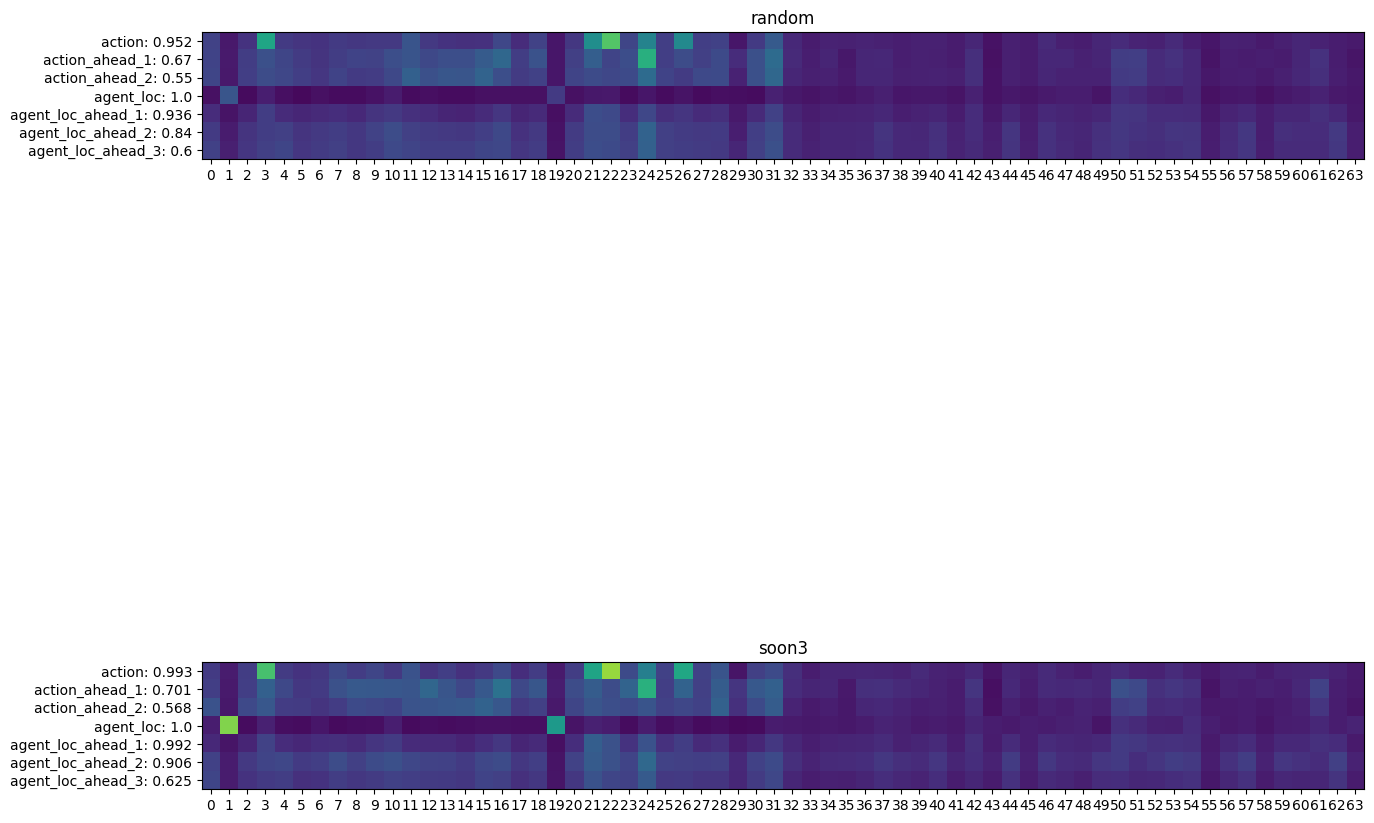

In [31]:
subsets = ["random", "soon3"]# "start3" # "adjbox", "noadjbox", "onebox"]
fig, axs = plt.subplots(len(subsets),1,figsize=(15,15))
for idx, subset in enumerate(subsets):
    results = pd.read_csv(f"./results/many_multi_{subset}.csv")
    maws_str = results.iloc[-1,:][1:].values
    maws_arr = np.zeros((7,64))
    for j,maws in enumerate(maws_str):
        maws = maws.strip("[]").split(", ")
        maws_arr[j,:] = [float(s) for s in maws]
    feats = ["_".join(s.split("_")[:-4]) for s in list(results.iloc[-1,:][1:].keys())]
    test_accs = [str(round(float(s),3)) for s in results.iloc[-2,:][1:].values.tolist()]
    labels = [": ".join([feats[k],test_accs[k]]) for k in range(len(test_accs))]
    axs[idx].imshow(maws_arr[:,:], vmin=0, vmax=2)
    axs[idx].set_yticks(ticks=[0,1,2,3,4,5,6], labels=labels)
    axs[idx].set_xticks(range(64)[:])
    axs[idx].set_title(subset)
plt.show()

In [5]:
from thinker.actor_net import DRCNet
import os
data = []
mini_sokoban = True
mini_unqtar = False
mini_unqbox = False
env_n = 1
gpu = False
exp = "cutoffpush"
num_steps = 3
for i in range(152):
    print(i)
    trans_entry = {}
    flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
    flags.mini = mini_sokoban
    flags.mini_unqbtar = mini_unqtar
    flags.mini_unqbox = mini_unqbox
    env = thinker.make(
        f"Sokoban-{exp}_clean_{i:04}-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, 
        has_model=False, 
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban,
        mini_unqtar=mini_unqtar,
        mini_unqbox=mini_unqbox         
    ) 

    drc_net = DRCNet(
        obs_space=env.observation_space,
        action_space=env.action_space,
        flags=flags,
        record_state=True,
        )
    drc_net.to(env.device)

    if i == 0:
        ckp_path = "../drc_mini"
        ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
        ckp = torch.load(ckp_path, env.device)
        drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset()
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
    for step in range(num_steps):
        actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        #viz.plot_mini_sokoban(state["real_states"][0])
        state, reward, done, info = env.step(actor_out.action)
        env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)

    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
    trans_entry["hidden_states"] = drc_net.hidden_state[0]
    trans_entry["block"] = 1

    data.append(trans_entry)
    trans_entry = {}

    env = thinker.make(
        f"Sokoban-{exp}_corrupt_{i:04}-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, 
        has_model=False, 
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban,
        mini_unqtar=mini_unqtar,
        mini_unqbox=mini_unqbox         
    ) 

    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset()
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
    for step in range(num_steps):
        actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        #viz.plot_mini_sokoban(state["real_states"][0])
        state, reward, done, info = env.step(actor_out.action)
        env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)

    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
    trans_entry["hidden_states"] = drc_net.hidden_state[0]
    trans_entry["block"] = 0
    data.append(trans_entry)

exp = "cutoffpush2"
for i in range(304):
    print(i)
    trans_entry = {}
    flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
    flags.mini = mini_sokoban
    flags.mini_unqbtar = mini_unqtar
    flags.mini_unqbox = mini_unqbox
    env = thinker.make(
        f"Sokoban-{exp}_clean_{i:04}-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, 
        has_model=False, 
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban,
        mini_unqtar=mini_unqtar,
        mini_unqbox=mini_unqbox         
    ) 

    #drc_net = DRCNet(
        #obs_space=env.observation_space,
        #action_space=env.action_space,
        #flags=flags,
        #record_state=True,
        #)
    #drc_net.to(env.device)

    #ckp_path = "../drc_mini"
    #ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
    #ckp = torch.load(ckp_path, env.device)
    #drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset()
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
    for step in range(num_steps):
        actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        #viz.plot_mini_sokoban(state["real_states"][0])
        state, reward, done, info = env.step(actor_out.action)
        env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)

    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
    trans_entry["hidden_states"] = drc_net.hidden_state[0]
    trans_entry["block"] = 1

    data.append(trans_entry)
    trans_entry = {}

    env = thinker.make(
        f"Sokoban-{exp}_corrupt_{i:04}-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, 
        has_model=False, 
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban,
        mini_unqtar=mini_unqtar,
        mini_unqbox=mini_unqbox         
    ) 

    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset()
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
    for step in range(num_steps):
        actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        #viz.plot_mini_sokoban(state["real_states"][0])
        state, reward, done, info = env.step(actor_out.action)
        env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)

    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
    trans_entry["hidden_states"] = drc_net.hidden_state[0]
    trans_entry["block"] = 0
    data.append(trans_entry)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


0


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


1


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


2


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


3


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


4


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


5


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


6


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


7


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


8


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


9


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


10


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


11


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


12


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


13


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


14


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


15


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


16


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


17


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


18


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


19


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


20


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


21


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


22


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


23


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


24


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


25


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


26


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


27


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


28


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


29


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


30


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


31


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


32


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


33


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


34


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


35


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


36


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


37


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


38


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


39


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


40


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


41


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


42


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


43


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


44


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


45


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


46


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


47


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


48


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


49


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


50


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


51


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


52


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


53


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


54


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


55


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


56


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


57


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


58


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


59


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


60


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


61


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


62


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


63


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


64


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


65


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


66


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


67


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


68


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


69


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


70


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


71


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


72


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


73


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


74


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


75


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


76


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


77


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


78


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


79


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


80


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


81


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


82


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


83


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


84


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


85


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


86


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


87


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


88


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


89


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


90


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


91


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


92


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


93


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


94


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


95


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


96


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


97


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


98


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


99


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


100


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


101


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


102


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


103


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


104


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


105


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


106


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


107


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


108


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


109


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


110


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


111


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


112


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


113


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


114


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


115


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


116


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


117


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


118


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


119


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


120


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


121


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


122


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


123


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


124


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


125


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


126


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


127


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


128


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


129


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


130


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


131


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


132


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


133


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


134


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


135


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


136


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


137


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


138


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


139


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


140


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


141


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


142


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


143


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


144


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


145


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


146


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


147


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


148


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


149


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


150


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


151


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


0


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


1


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


2


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


3


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


4


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


5


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


6


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


7


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


8


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


9


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


10


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


11


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


12


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


13


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


14


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


15


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


16


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


17


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


18


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


19


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


20


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


21


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


22


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


23


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


24


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


25


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


26


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


27


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


28


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


29


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


30


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


31


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


32


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


33


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


34


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


35


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


36


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


37


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


38


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


39


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


40


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


41


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


42


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


43


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


44


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


45


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


46


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


47


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


48


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


49


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


50


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


51


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


52


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


53


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


54


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


55


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


56


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


57


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


58


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


59


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


60


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


61


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


62


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


63


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


64


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


65


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


66


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


67


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


68


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


69


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


70


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


71


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


72


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


73


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


74


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


75


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


76


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


77


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


78


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


79


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


80


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


81


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


82


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


83


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


84


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


85


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


86


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


87


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


88


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


89


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


90


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


91


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


92


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


93


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


94


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


95


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


96


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


97


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


98


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


99


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


100


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


101


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


102


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


103


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


104


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


105


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


106


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


107


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


108


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


109


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


110


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


111


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


112


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


113


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


114


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


115


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


116


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


117


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


118


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


119


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


120


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


121


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


122


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


123


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


124


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


125


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


126


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


127


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


128


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
terminate called after throwing an instance of 'std::runtime_error'
  what():  box_left must be equal to 4 (room_id: 0)


EOFError: 

In [5]:
from random import shuffle

In [6]:
shuffle(data)

NameError: name 'shuffle' is not defined

In [6]:
data[0]

{'hidden_states': tensor([[[[-4.4742e-03,  2.3729e-02,  5.7692e-02,  ...,  4.5902e-02,
             3.2848e-02,  2.2819e-02],
           [-2.9262e-02,  4.0882e-02,  6.0277e-02,  ...,  9.1003e-02,
             8.6360e-02,  6.0544e-02],
           [-2.3136e-02,  4.5311e-02,  6.7359e-02,  ...,  6.4876e-02,
             8.8771e-02,  5.2745e-02],
           ...,
           [-2.9049e-02,  2.8230e-02,  9.5425e-02,  ...,  4.1941e-02,
             4.5048e-02,  1.9830e-02],
           [-3.2191e-02,  1.1309e-03,  2.5898e-02,  ...,  1.9262e-02,
             3.4750e-02,  1.7930e-02],
           [-5.8987e-02, -3.7270e-02, -2.9909e-02,  ..., -1.4518e-02,
            -2.2539e-02,  1.2812e-02]],
 
          [[ 2.4206e-02,  8.2810e-02,  4.3156e-02,  ...,  5.3944e-02,
             6.5225e-02,  3.4133e-02],
           [-2.5942e-03,  1.4907e-02, -4.0922e-02,  ..., -4.5667e-02,
            -4.5190e-03, -6.0200e-02],
           [ 9.5674e-03, -4.1094e-02, -3.5861e-02,  ..., -1.8115e-02,
            -2.0433e-0

In [7]:
torch.save(ProbingDataset(data[:-50]), f"./data/MINItrain_data.pt")
torch.save(ProbingDataset(data[-50:]), f"./data/MINItest_data.pt")
torch.save(ProbingDataset(data[-50:]), f"./data/MINIval_data.pt")

Initializing env 0 with device cpu


Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


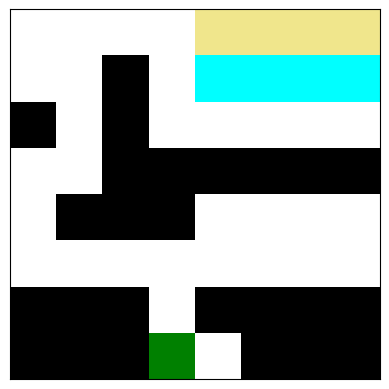

In [9]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

env = thinker.make(
    f"Sokoban-shortcutpush_clean_0000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset()
episode_entry_1 = [] 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state, reward, done, info = env.step(actor_out.action)
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
actor_out, new_rnn_state = drc_net(env_out, rnn_state, greedy=True)
episode_entry_1.append({"board_state": state["real_states"][0], "hidden_states": drc_net.hidden_state[0]})
viz.plot_mini_sokoban(state["real_states"][0])

In [135]:
val_data = torch.load("./data/val_data_full.pt")

In [65]:
import numpy as np
from sklearn.decomposition import PCA   

In [124]:
len(val_data)

81984

In [150]:
tensors = []
states = []
for i in range(0, len(val_data)):
    tensors.append(val_data[i]["hidden_states"][0,160:192,:,:].reshape(32,64).permute(1,0))
    states.append(val_data[i]["board_state"])
x_data = torch.concat(tensors, dim=0)

In [151]:
pca = PCA(n_components=12)
x_new = pca.fit_transform(x_data)
x_new = torch.tensor(x_new).reshape(len(tensors),8,8,12)

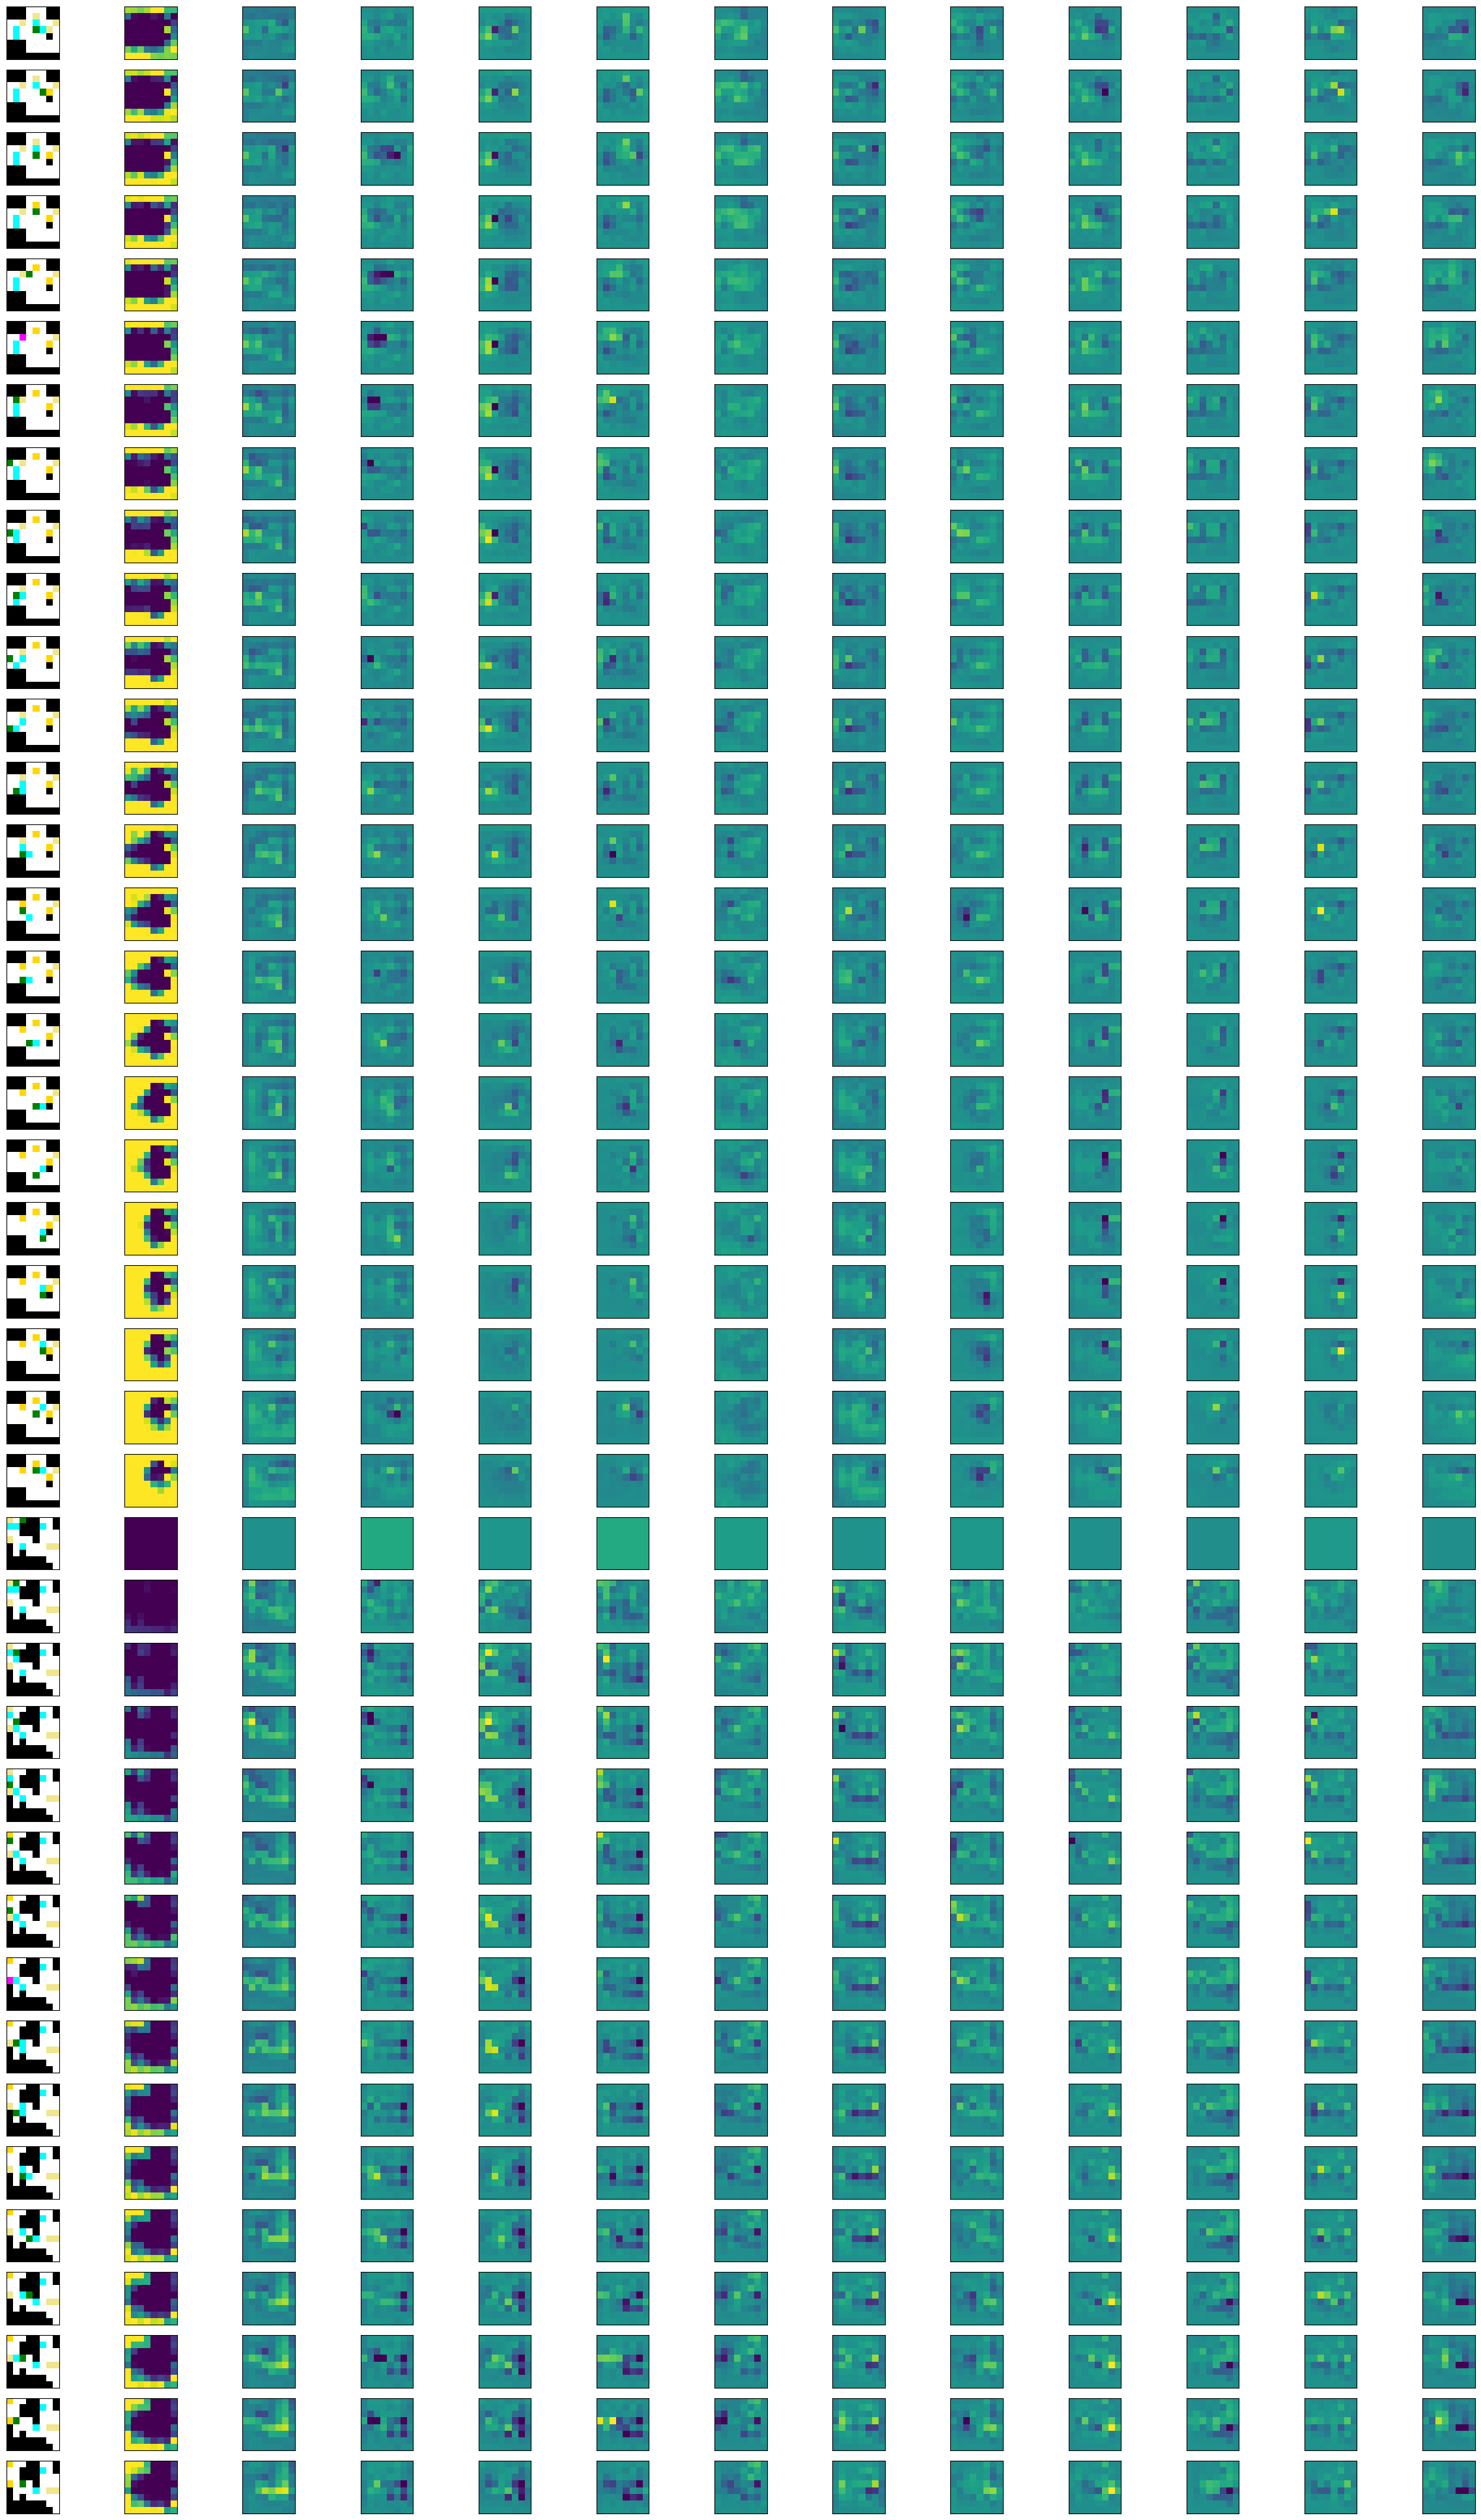

In [152]:
fig, axs = plt.subplots(40,13, figsize=(30,50))
cur_states = states[120:]
cur_x_new = x_new[120:]
for j in range(40):
    state = cur_states[j]
    if state.shape[0] != state.shape[1]:
        state = state.permute(1,2,0)
    dim_z = 7
    mini_board = np.zeros(state.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    axs[j][0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[j][0].axes.get_yaxis().set_visible(False)
    axs[j][0].axes.get_xaxis().set_visible(False)
    for i in range(12):
        axs[j][i+1].imshow(np.flip(cur_x_new[j,:,:,i].numpy(), axis=0), interpolation='nearest', origin='lower', vmin=-2, vmax=2)
        axs[j][i+1].axes.get_yaxis().set_visible(False)
        axs[j][i+1].axes.get_xaxis().set_visible(False)

In [133]:
x_new.max()

tensor(1.1091, dtype=torch.float64)

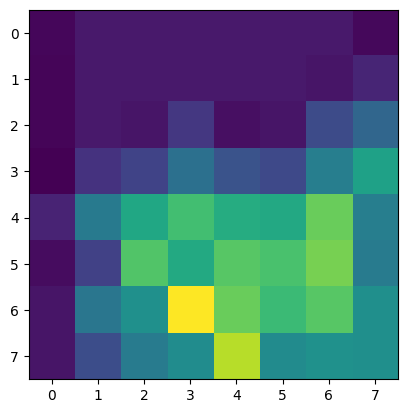

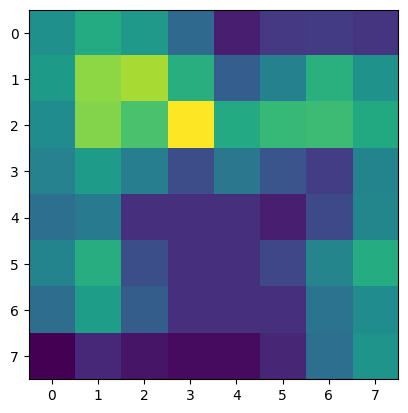

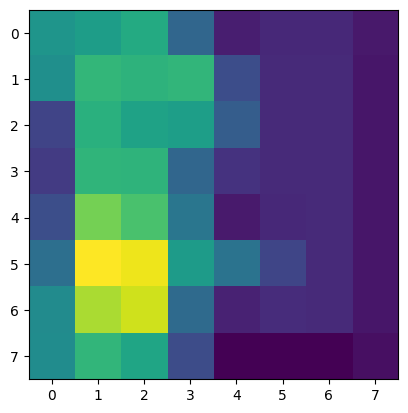

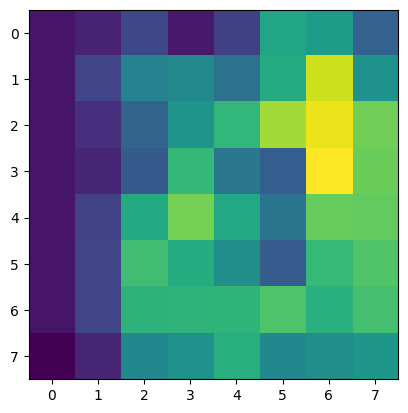

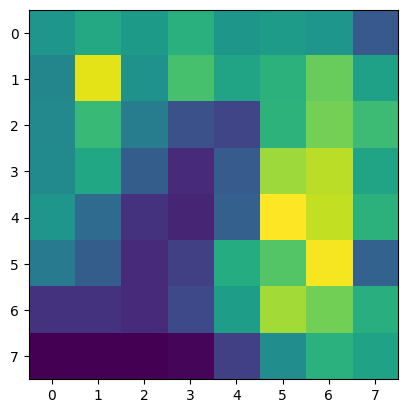

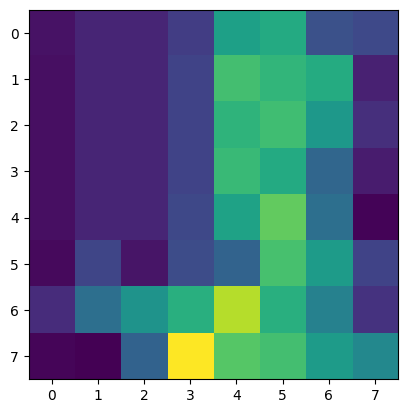

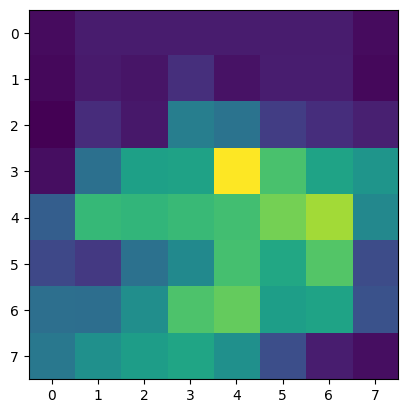

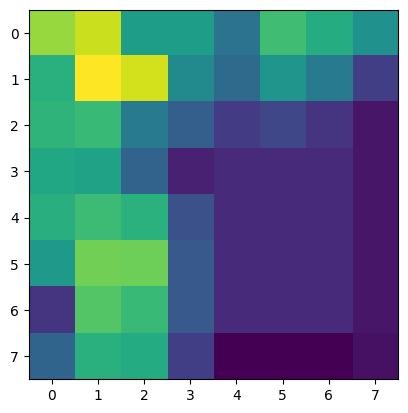

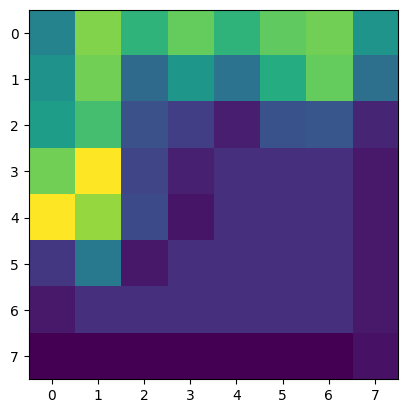

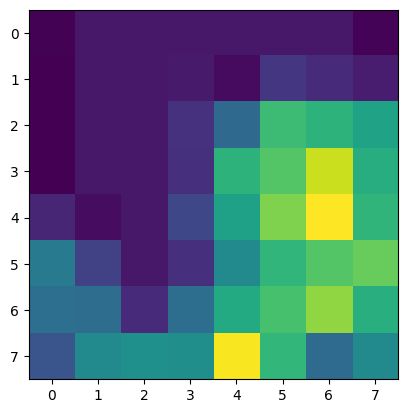

In [99]:
for i in range(10):
    plt.imshow(x_new[i,:,:,0])
    plt.show()